변수 중요도 (SHAP)

In [ ]:
!pip install optuna
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
import optuna
import shap
import json
import warnings
import re
warnings.filterwarnings("ignore")

# 산업 PER 기반 피처 계산 (IQR 이상치 제거 후 조화평균)
def calculate_industry_per_feature(df):
    """산업별 PER을 계산하며, IQR로 이상치를 제거한 후 조화평균을 적용"""
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    industries = df[industry_cols].stack().dropna().unique()

    harm_means = {}
    for ind in industries:
        mask = df[industry_cols].apply(lambda r: ind in r.values, axis=1)
        sub = df.loc[mask & df['Net Income (LTM)'].gt(0) & df['Net Income (LTM)'].notna()]
        per_vals = sub['market_cap'] / sub['Net Income (LTM)']

        if len(per_vals) > 0:
            q1 = per_vals.quantile(0.25)
            q3 = per_vals.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 2 * iqr
            upper_bound = q3 + 2 * iqr
            per_vals_filtered = per_vals[(per_vals >= lower_bound) & (per_vals <= upper_bound)]
            harm_means[ind] = len(per_vals_filtered) / (1.0 / per_vals_filtered).sum() if len(per_vals_filtered) > 0 else np.nan
        else:
            harm_means[ind] = np.nan

    def feature(row):
        nets = row['Net Income (LTM)']
        if nets <= 0 or pd.isna(nets):
            return np.nan
        inds = [row[c] for c in industry_cols if pd.notna(row[c])]
        hms = [harm_means[i] for i in inds if not np.isnan(harm_means.get(i, np.nan))]
        return np.mean(hms) * nets if hms else np.nan

    return df.apply(feature, axis=1)

# 산업 EV/EBITDA 기반 피처 계산 (IQR 이상치 제거 후 조화평균)
def calculate_industry_EV_EBITDA_feature(df):
    """산업별 EV/EBITDA를 계산하며, IQR로 이상치를 제거한 후 조화평균을 적용"""
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    industries = df[industry_cols].stack().dropna().unique()

    harm_means_ev = {}
    for ind in industries:
        mask = df[industry_cols].apply(lambda r: ind in r.values, axis=1)
        sub = df.loc[mask & df['EBITDA (LTM)'].gt(0) & df['EBITDA (LTM)'].notna() & df['Enterprise Value (FQ0)'].notna()]
        ev_vals = sub['Enterprise Value (FQ0)'] / sub['EBITDA (LTM)']

        if len(ev_vals) > 0:
            q1 = ev_vals.quantile(0.25)
            q3 = ev_vals.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 2 * iqr
            upper_bound = q3 + 2 * iqr
            ev_vals_filtered = ev_vals[(ev_vals >= lower_bound) & (ev_vals <= upper_bound)]
            harm_means_ev[ind] = len(ev_vals_filtered) / (1.0 / ev_vals_filtered).sum() if len(ev_vals_filtered) > 0 else np.nan
        else:
            harm_means_ev[ind] = np.nan

    def feature_ev(row):
        ebitda = row['EBITDA (LTM)']
        if ebitda <= 0 or pd.isna(ebitda):
            return np.nan
        inds = [row[c] for c in industry_cols if pd.notna(row[c])]
        hms = [harm_means_ev[i] for i in inds if not np.isnan(harm_means_ev.get(i, np.nan))]
        return np.mean(hms) * ebitda if hms else np.nan

    return df.apply(feature_ev, axis=1)

# 도메인 및 시간 기반 피처 엔지니어링 클래스
class DomainFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        Xt = self._transform(X.copy())
        self.cols_ = Xt.columns.tolist()
        print(f"\n사용 가능한 변수 리스트 ({len(self.cols_)}개):")
        for col in self.cols_:
            print(f"  {col}")
        return self

    def transform(self, X):
        Xt = self._transform(X.copy())
        return Xt.reindex(columns=self.cols_, fill_value=0)

    def _transform(self, X):
        X = X.drop('market', axis=1, errors='ignore')
        tcols = [c for c in X.columns if '(' in c and 'LTM' in c]
        tf = {}
        for c in tcols:
            base, per = c.split(' (')
            tf.setdefault(base, {})[per.rstrip(')')] = c

        if 'EBIT' in tf and 'Depreciation' in tf:
            for p, e in tf['EBIT'].items():
                d = tf['Depreciation'].get(p)
                if d:
                    X[f'EBITDA ({p})'] = X[e] + X[d]
            tf['EBITDA'] = {p: f'EBITDA ({p})' for p in tf['EBIT']}

        bases = ['Total Assets', 'Total Liabilities', 'Equity', 'Net Debt',
                 'Revenue', 'EBIT', 'EBITDA', 'Net Income', 'Net Income After Minority', 'Dividends']

        def safe_div(a, b):
            return a.div(b.replace({0: np.nan}))

        for v in bases:
            periods = tf.get(v, {})
            seq = [p for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if p in periods]
            grs = []
            for i in range(1, len(seq)):
                prev, curr = seq[i-1], seq[i]
                r = safe_div(X[periods[curr]] - X[periods[prev]], X[periods[prev]])
                suffix = '-2' if (prev, curr) == ('LTM-3', 'LTM-2') else '-1' if (prev, curr) == ('LTM-2', 'LTM-1') else ''
                X[f'{v}_growth{suffix}'] = r
                grs.append(r)
            if grs:
                X[f'{v}_avg_growth'] = pd.concat(grs, axis=1).mean(axis=1)
                X[f'{v}_volatility'] = X[[periods[p] for p in seq]].std(axis=1)
            if 'LTM-3' in periods and 'LTM' in periods:
                X[f'{v}_CAGR'] = np.where(
                    X[periods['LTM-3']] > 0,
                    (X[periods['LTM']] / X[periods['LTM-3']])**(1/3) - 1,
                    np.nan
                )

        def calc(a, b, name, per):
            if per in tf.get(a, {}) and per in tf.get(b, {}):
                X[f'{name} ({per})'] = safe_div(X[tf[a][per]], X[tf[b][per]])

        ratios = [
            ('Equity', 'Total Assets', 'BAR'),
            ('Total Liabilities', 'Equity', 'DBR'),
            ('Revenue', 'Total Assets', 'SAR'),
            ('EBIT', 'Revenue', 'OMR'),
            ('EBITDA', 'Revenue', 'EMR'),
            ('Net Income', 'Total Assets', 'EAR'),
            ('Net Income', 'Equity', 'EBR')
        ]
        for p in ['LTM', 'LTM-1', 'LTM-2', 'LTM-3']:
            for a, b, n in ratios:
                calc(a, b, n, p)
            if p in ['LTM-2', 'LTM-1', 'LTM']:
                ni = tf.get('Net Income After Minority', {}).get(p)
                eq = tf.get('Equity', {}).get(p)
                prev = {'LTM-2': 'LTM-3', 'LTM-1': 'LTM-2', 'LTM': 'LTM-1'}[p]
                ep = tf.get('Equity', {}).get(prev)
                if ni and eq and ep:
                    avg_eq = (X[eq] + X[ep]) / 2
                    X[f'ROE ({p})'] = safe_div(X[ni], avg_eq)

        ratio_bases = ['BAR', 'DBR', 'SAR', 'OMR', 'EMR', 'EAR', 'EBR', 'ROE']
        for v in ratio_bases:
            periods = {p: f'{v} ({p})' for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if f'{v} ({p})' in X.columns}
            seq = [p for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if p in periods]
            grs = []
            for i in range(1, len(seq)):
                prev, curr = seq[i-1], seq[i]
                r = safe_div(X[periods[curr]] - X[periods[prev]], X[periods[prev]])
                suffix = '-2' if (prev, curr) == ('LTM-3', 'LTM-2') else '-1' if (prev, curr) == ('LTM-2', 'LTM-1') else ''
                X[f'{v}_growth{suffix}'] = r
                grs.append(r)
            if grs:
                X[f'{v}_avg_growth'] = pd.concat(grs, axis=1).mean(axis=1)
                X[f'{v}_volatility'] = X[[periods[p] for p in seq]].std(axis=1)
            if 'LTM-3' in periods and 'LTM' in periods:
                X[f'{v}_CAGR'] = np.where(
                    X[periods['LTM-3']] > 0,
                    (X[periods['LTM']] / X[periods['LTM-3']])**(1/3) - 1,
                    np.nan
                )

        dep_cols = [c for c in X.columns if c.startswith('Depreciation')]
        if dep_cols:
            X.drop(columns=dep_cols, inplace=True)

        industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
        for col in industry_cols:
            if col in X.columns:
                X[col] = X[col].astype('category')

        exclude_cols = [col for col in X.columns if re.search(r'\(LTM-\d+\)$|_growth-\d+$', col)]
        X = X.drop(columns=exclude_cols)

        return X

# LightGBM 하이퍼파라미터 최적화 (0.5 quantile)
def optimize_lightgbm(X, y, n_trials=50):
    """LightGBM 모델의 하이퍼파라미터를 최적화하며 0.5 quantile loss를 최소화"""
    def objective(trial):
        param = {
            'objective': 'quantile',
            'alpha': 0.5,
            'n_estimators': 1000,  # Large number, early stopping will adjust
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        val_losses = []
        cat_cols = [col for col in ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5'] if col in X.columns]

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = LGBMRegressor(**param)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='quantile',
                callbacks=[early_stopping(stopping_rounds=10, verbose=False)],
                categorical_feature=cat_cols
            )
            y_pred = model.predict(X_val)
            loss = np.mean(np.where(y_val >= y_pred, 0.5 * (y_val - y_pred), 0.5 * (y_pred - y_val)))
            val_losses.append(loss)

        return np.mean(val_losses)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)
    best_params = study.best_params
    best_params.update({
        'objective': 'quantile',
        'alpha': 0.5,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    })
    return best_params

# LightGBM 0.5 quantile 모델 실행 및 SHAP 분석
def quick_lightgbm_quantile(df, name):
    """LightGBM 0.5 quantile 모델을 실행하고 SHAP 피처 중요도를 계산 및 시각화"""
    df = df.copy()

    # EBITDA 생성
    if 'EBITDA (LTM)' not in df and 'EBIT (LTM)' in df and 'Depreciation (LTM)' in df:
        df['EBITDA (LTM)'] = df['EBIT (LTM)'] + df['Depreciation (LTM)']

    # 상장일 변환
    df['Listing_Age_Days'] = (pd.to_datetime('2024-12-31') - pd.to_datetime(df['Listing Date'])).dt.days
    df.drop(columns=['Listing Date'], inplace=True)

    # 산업 피처 계산
    df['industry_PER_feature'] = calculate_industry_per_feature(df)
    df['industry_EV_EBITDA_feature'] = calculate_industry_EV_EBITDA_feature(df)

    # 카테고리 변수 설정
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    for col in industry_cols:
        if col in df:
            df[col] = df[col].astype('category')

    # 설명 변수 선택
    X = df.select_dtypes(include=[np.number, 'category']).drop(
        columns=['Market Cap (2024-12-31)', 'market_cap', 'Enterprise Value (FQ0)'], errors='ignore')
    y = df['market_cap']

    # 피처 엔지니어링
    fe = DomainFeatureEngineer().fit(X, y)
    X_fe = fe.transform(X)

    # 피처 선택
    selector = LGBMRegressor(n_estimators=200, random_state=42)
    selector.fit(X_fe, y)
    imp = pd.Series(selector.feature_importances_, index=X_fe.columns)
    selected = imp[imp > imp.mean() * 1.2].sort_values(ascending=False).index.tolist()

    print(f"\n[{name}] 선택된 피처 ({len(selected)}개):")
    for feat, score in imp[imp > imp.mean()].sort_values(ascending=False).items():
        print(f"  {feat}: {score:.2f}")

    # 모델 최적화 및 학습
    X_sel = X_fe[selected]
    best_params = optimize_lightgbm(X_sel, y)
    cat_cols = [col for col in industry_cols if col in X_sel.columns]

    model = LGBMRegressor(**best_params)
    model.fit(X_sel, y, categorical_feature=cat_cols)

    # SHAP 값 계산
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sel)

    # 피처 중요도 계산
    shap_importances = np.abs(shap_values).mean(axis=0)
    feature_importance_df = pd.DataFrame({
        'feature': X_sel.columns,
        'importance': shap_importances
    }).sort_values(by='importance', ascending=False)

    print(f"\n[{name}] SHAP Feature Importances (Top 10):")
    display(feature_importance_df.head(10))

    # 상위 10개 피처 시각화
    top_features = feature_importance_df.head(10)
    chart_data = {
        'type': 'bar',
        'data': {
            'labels': top_features['feature'].tolist(),
            'datasets': [{
                'label': 'SHAP Importance',
                'data': top_features['importance'].tolist(),
                'backgroundColor': 'rgba(54, 162, 235, 0.8)',
                'borderColor': 'rgba(54, 162, 235, 1)',
                'borderWidth': 1
            }]
        },
        'options': {
            'indexAxis': 'y',  # Horizontal bar chart
            'scales': {
                'x': {
                    'beginAtZero': True
                }
            },
            'plugins': {
                'legend': {
                    'display': False
                },
                'title': {
                    'display': True,
                    'text': f'Top 10 Feature Importances for {name}'
                }
            }
        }
    }

    print("\n```chartjs")
    print(json.dumps(chart_data, indent=2))
    print("```")

    return feature_importance_df

# 메인 실행
if __name__ == "__main__":
    PATH = "/content/5_7_데이터.xlsx"
    df = pd.read_excel(PATH, sheet_name="Sheet1")

    # 데이터 전처리
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    for col in industry_cols:
        if col in df:
            df[col] = df[col].astype('category')

    df = df[df["market"].isin(["KOSDAQ", "KOSDAQ GLOBAL", "KOSPI"]) & (df["Market Cap (2024-12-31)"] > 0)]
    df["market_cap"] = df["Market Cap (2024-12-31)"]

    exclude_tickers = set(['003380', '005290', '005990', '006730', '007330', '012700', '013120', '013310', '015750', '016250',
                           '018310', '019210', '021320', '023410', '023760', '025900', '025980', '027710', '028300', '030530',
                           '031330', '032190', '033160', '033290', '033640', '034810', '035080', '035600', '035760', '035810',
                           '035890', '035900', '036710', '036800', '036830', '036930', '037460', '038110', '038390', '038500',
                           '038540', '041190', '041510', '043370', '046890', '049070', '051500', '053700', '056190', '058470',
                           '061970', '064760', '064820', '067160', '067170', '067310', '067570', '067990', '069080', '071460',
                           '074600', '078020', '078340', '080420', '084110', '084850', '085660', '086520', '091700', '092190',
                           '096530', '100790', '101330', '104480', '112040', '115160', '121440', '122450', '122690', '123040',
                           '124500', '131970', '136480', '137400', '141080', '145020', '151860', '178320', '195940', '205470',
                           '214450', '215000', '215200', '222800', '240810', '247540', '253450', '263750', '267980', '293490',
                           '348370', '357780', '393890', '403870', '900290', '950130', '000270', '000660', '000810', '000880',
                           '001040', '003490', '003550', '004020', '005380', '005490', '005830', '005930', '005940', '006400',
                           '006800', '009540', '010950', '011170', '011200', '012330', '015760', '016360', '017670', '023530',
                           '023590', '024110', '028260', '030200', '032830', '034220', '034730', '035420', '035720', '036460',
                           '042660', '051910', '055550', '066570', '071050', '078930', '086790', '088350', '096770', '097950',
                           '105560', '138040', '138930', '139130', '139480', '207940', '267250', '316140', '373220', '402340',
                           '415640'])
    df = df[~df['ticker'].isin(exclude_tickers)].reset_index(drop=True)

    num_cols = df.select_dtypes(include=[np.number]).columns
    df = df[df[num_cols].isnull().mean(axis=1) <= 0.5].reset_index(drop=True)

    # 시장별 데이터 분리 및 모델 실행
    kosdaq = df[df["market"].isin(["KOSDAQ", "KOSDAQ GLOBAL"])]
    kospi = df[df["market"] == "KOSPI"]

    res1 = quick_lightgbm_quantile(kosdaq, "KOSDAQ & KOSDAQ GLOBAL")
    res2 = quick_lightgbm_quantile(kospi, "KOSPI")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.1 MB/s eta 0:00:00

사용 가능한 변수 리스트 (97개):
  Industry1
  Industry2
  Industry3
  Industry4
  Industry5
  Net Debt (LTM)
  Total Liabilities (LTM)
  Total Assets (LTM)
  Equity (LTM)
  Revenue (LTM)
  Net Income (LTM)
  Net Income After Minority (LTM)
  EBIT (LTM)
  Dividends (LTM)
  EBITDA (LTM)
  Listing_Age_Days
  industry_PER_feature
  industry_EV_EBITDA_feature
  Total Assets_growth
  Total Assets_avg_growth
  Total Assets_volatility
  Total Assets_CAGR
  Total Liabilities_growth
  Total Liabilities_avg_growth
  Total Liabilities_volatility
  Total Liabilities_CAGR
  Equity_growth
  Equity_avg_growth
  Equity_volatility
  Equity_CAGR
  Net Debt_growth
  Net Debt_avg_growth
  Net Debt_volatility
  Net Debt_CAGR
  Revenue_growth
  Revenue_avg_growth
  Revenue_volatility
  Revenue_CAGR
  EBIT_growth
  EBIT_avg_growth
  EBIT_volatility
  EBIT_CAGR

[I 2025-05-24 09:01:38,518] A new study created in memory with name: no-name-b844fdd1-bfa2-442a-905b-34357e167723



[KOSDAQ & KOSDAQ GLOBAL] 선택된 피처 (27개):
  Net Debt_volatility: 295.00
  SAR_CAGR: 228.00
  Total Assets (LTM): 199.00
  Total Assets_volatility: 180.00
  Equity_volatility: 177.00
  Net Debt_growth: 164.00
  Equity (LTM): 145.00
  OMR_volatility: 144.00
  Net Debt (LTM): 141.00
  EMR_volatility: 136.00
  EMR_growth: 123.00
  Revenue_CAGR: 122.00
  Total Liabilities (LTM): 118.00
  Industry1: 100.00
  ROE_volatility: 87.00
  EAR_volatility: 87.00
  Dividends_growth: 85.00
  Revenue (LTM): 83.00
  Net Debt_avg_growth: 83.00
  Equity_CAGR: 81.00
  EMR (LTM): 81.00
  ROE_avg_growth: 80.00
  Total Assets_growth: 80.00
  OMR (LTM): 80.00
  industry_EV_EBITDA_feature: 78.00
  Net Income After Minority_avg_growth: 76.00
  SAR_volatility: 76.00
  EBITDA_growth: 72.00
  EBITDA (LTM): 72.00
  SAR (LTM): 66.00
  SAR_growth: 65.00
  Equity_growth: 64.00
  BAR_volatility: 64.00
  EBIT (LTM): 63.00


[I 2025-05-24 09:01:39,245] Trial 1 finished with value: 50869239408.45605 and parameters: {'learning_rate': 0.18508247419768206, 'num_leaves': 145, 'max_depth': 11, 'min_child_samples': 54, 'subsample': 0.6565132070621643, 'colsample_bytree': 0.702819322186102, 'reg_alpha': 8.295972068831338, 'reg_lambda': 4.107256931691234}. Best is trial 1 with value: 50869239408.45605.
[I 2025-05-24 09:01:39,915] Trial 0 finished with value: 50722622530.40901 and parameters: {'learning_rate': 0.19892352706619582, 'num_leaves': 32, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.9427684812263726, 'colsample_bytree': 0.8633672696787258, 'reg_alpha': 5.250731125967132, 'reg_lambda': 1.2252442669291321}. Best is trial 0 with value: 50722622530.40901.
[I 2025-05-24 09:01:40,533] Trial 3 finished with value: 51134760979.68946 and parameters: {'learning_rate': 0.28834520186002, 'num_leaves': 36, 'max_depth': 12, 'min_child_samples': 44, 'subsample': 0.8585967246071996, 'colsample_bytree': 0.84988


[KOSDAQ & KOSDAQ GLOBAL] SHAP Feature Importances (Top 10):


,feature,importance
6,Equity (LTM),2.069701e+10
4,Equity_volatility,1.336091e+10
2,Total Assets (LTM),1.155172e+10
20,EMR (LTM),9.925623e+09
13,Industry1,9.230348e+09
24,industry_EV_EBITDA_feature,7.911926e+09
23,OMR (LTM),6.062618e+09
8,Net Debt (LTM),5.714242e+09
7,OMR_volatility,4.832999e+09
22,Total Assets_growth,4.770720e+09



```chartjs
{
  "type": "bar",
  "data": {
    "labels": [
      "Equity (LTM)",
      "Equity_volatility",
      "Total Assets (LTM)",
      "EMR (LTM)",
      "Industry1",
      "industry_EV_EBITDA_feature",
      "OMR (LTM)",
      "Net Debt (LTM)",
      "OMR_volatility",
      "Total Assets_growth"
    ],
    "datasets": [
      {
        "label": "SHAP Importance",
        "data": [
          20697012481.440968,
          13360912338.522564,
          11551719899.845438,
          9925622515.546627,
          9230348250.744387,
          7911925608.222622,
          6062617883.489176,
          5714242250.782657,
          4832998702.90818,
          4770720142.464085
        ],
        "backgroundColor": "rgba(54, 162, 235, 0.8)",
        "borderColor": "rgba(54, 162, 235, 1)",
        "borderWidth": 1
      }
    ]
  },
  "options": {
    "indexAxis": "y",
    "scales": {
      "x": {
        "beginAtZero": true
      }
    },
    "plugins": {
      "legend": {
        "display

[I 2025-05-24 09:02:33,303] A new study created in memory with name: no-name-a2891217-df1a-4926-bf88-665af6622265



[KOSPI] 선택된 피처 (31개):
  Listing_Age_Days: 188.00
  Dividends_growth: 186.00
  Equity (LTM): 160.00
  Net Income After Minority (LTM): 137.00
  Equity_volatility: 137.00
  Dividends (LTM): 124.00
  Dividends_volatility: 122.00
  Total Assets_volatility: 116.00
  Revenue_volatility: 115.00
  industry_EV_EBITDA_feature: 113.00
  Total Liabilities_volatility: 113.00
  DBR_growth: 111.00
  Equity_growth: 104.00
  Net Debt_volatility: 100.00
  industry_PER_feature: 100.00
  Dividends_avg_growth: 99.00
  Total Liabilities_CAGR: 96.00
  Revenue_growth: 94.00
  EBITDA_volatility: 91.00
  EBIT (LTM): 90.00
  EAR_CAGR: 88.00
  Net Income After Minority_volatility: 86.00
  EBR_CAGR: 85.00
  SAR_growth: 82.00
  Net Income_volatility: 81.00
  Revenue_CAGR: 78.00
  EBIT_volatility: 78.00
  Dividends_CAGR: 76.00
  SAR_volatility: 73.00
  SAR_CAGR: 73.00
  Net Income After Minority_avg_growth: 73.00
  BAR_volatility: 72.00
  Net Income_CAGR: 71.00
  Net Debt_growth: 70.00
  Revenue (LTM): 68.00
  SAR 

[I 2025-05-24 09:02:33,848] Trial 1 finished with value: 303274311994.55383 and parameters: {'learning_rate': 0.08009457372034368, 'num_leaves': 20, 'max_depth': 4, 'min_child_samples': 41, 'subsample': 0.718242772217295, 'colsample_bytree': 0.6730922376709161, 'reg_alpha': 9.510351269093768, 'reg_lambda': 5.560942484374334}. Best is trial 1 with value: 303274311994.55383.
[I 2025-05-24 09:02:34,301] Trial 2 finished with value: 315582992654.3805 and parameters: {'learning_rate': 0.1565130699194791, 'num_leaves': 81, 'max_depth': 6, 'min_child_samples': 95, 'subsample': 0.8002792523569329, 'colsample_bytree': 0.7545202425889009, 'reg_alpha': 2.944215375986283, 'reg_lambda': 6.75175355798276}. Best is trial 1 with value: 303274311994.55383.
[I 2025-05-24 09:02:34,525] Trial 0 finished with value: 303511004301.8393 and parameters: {'learning_rate': 0.032607362187712444, 'num_leaves': 55, 'max_depth': 13, 'min_child_samples': 45, 'subsample': 0.8470961122333516, 'colsample_bytree': 0.8739


[KOSPI] SHAP Feature Importances (Top 10):


,feature,importance
3,Equity_volatility,1.382544e+11
19,EBIT (LTM),1.072317e+11
2,Equity (LTM),9.600225e+10
4,Net Income After Minority (LTM),9.128559e+10
5,Dividends (LTM),7.839841e+10
14,industry_PER_feature,5.409245e+10
21,Net Income After Minority_volatility,5.110253e+10
10,Total Liabilities_volatility,4.778942e+10
0,Listing_Age_Days,4.053962e+10
6,Dividends_volatility,3.172565e+10



```chartjs
{
  "type": "bar",
  "data": {
    "labels": [
      "Equity_volatility",
      "EBIT (LTM)",
      "Equity (LTM)",
      "Net Income After Minority (LTM)",
      "Dividends (LTM)",
      "industry_PER_feature",
      "Net Income After Minority_volatility",
      "Total Liabilities_volatility",
      "Listing_Age_Days",
      "Dividends_volatility"
    ],
    "datasets": [
      {
        "label": "SHAP Importance",
        "data": [
          138254445557.3209,
          107231651588.17908,
          96002247120.98134,
          91285589885.36652,
          78398411342.24345,
          54092451600.23693,
          51102525446.853035,
          47789423353.50039,
          40539617087.80914,
          31725649111.5675
        ],
        "backgroundColor": "rgba(54, 162, 235, 0.8)",
        "borderColor": "rgba(54, 162, 235, 1)",
        "borderWidth": 1
      }
    ]
  },
  "options": {
    "indexAxis": "y",
    "scales": {
      "x": {
        "beginAtZero": true
      }
 


사용 가능한 변수 리스트 (97개):
  Industry1
  Industry2
  Industry3
  Industry4
  Industry5
  Net Debt (LTM)
  Total Liabilities (LTM)
  Total Assets (LTM)
  Equity (LTM)
  Revenue (LTM)
  Net Income (LTM)
  Net Income After Minority (LTM)
  EBIT (LTM)
  Dividends (LTM)
  EBITDA (LTM)
  Listing_Age_Days
  industry_PER_feature
  industry_EV_EBITDA_feature
  Total Assets_growth
  Total Assets_avg_growth
  Total Assets_volatility
  Total Assets_CAGR
  Total Liabilities_growth
  Total Liabilities_avg_growth
  Total Liabilities_volatility
  Total Liabilities_CAGR
  Equity_growth
  Equity_avg_growth
  Equity_volatility
  Equity_CAGR
  Net Debt_growth
  Net Debt_avg_growth
  Net Debt_volatility
  Net Debt_CAGR
  Revenue_growth
  Revenue_avg_growth
  Revenue_volatility
  Revenue_CAGR
  EBIT_growth
  EBIT_avg_growth
  EBIT_volatility
  EBIT_CAGR
  EBITDA_growth
  EBITDA_avg_growth
  EBITDA_volatility
  EBITDA_CAGR
  Net Income_growth
  Net Income_avg_growth
  Net Income_volatility
  Net Income_CAGR
  Net

[I 2025-05-24 09:09:41,211] A new study created in memory with name: no-name-d0c7ebf4-ae1b-4811-b84d-ed8068117b8e



[KOSDAQ & KOSDAQ GLOBAL] 선택된 피처 (27개):
  Net Debt_volatility: 295.00
  SAR_CAGR: 228.00
  Total Assets (LTM): 199.00
  Total Assets_volatility: 180.00
  Equity_volatility: 177.00
  Net Debt_growth: 164.00
  Equity (LTM): 145.00
  OMR_volatility: 144.00
  Net Debt (LTM): 141.00
  EMR_volatility: 136.00
  EMR_growth: 123.00
  Revenue_CAGR: 122.00
  Total Liabilities (LTM): 118.00
  Industry1: 100.00
  ROE_volatility: 87.00
  EAR_volatility: 87.00
  Dividends_growth: 85.00
  Revenue (LTM): 83.00
  Net Debt_avg_growth: 83.00
  Equity_CAGR: 81.00
  EMR (LTM): 81.00
  ROE_avg_growth: 80.00
  Total Assets_growth: 80.00
  OMR (LTM): 80.00
  industry_EV_EBITDA_feature: 78.00
  Net Income After Minority_avg_growth: 76.00
  SAR_volatility: 76.00
  EBITDA_growth: 72.00
  EBITDA (LTM): 72.00
  SAR (LTM): 66.00
  SAR_growth: 65.00
  Equity_growth: 64.00
  BAR_volatility: 64.00
  EBIT (LTM): 63.00


[I 2025-05-24 09:09:41,801] Trial 1 finished with value: 50786376737.43138 and parameters: {'learning_rate': 0.24787459755429236, 'num_leaves': 149, 'max_depth': 12, 'min_child_samples': 41, 'subsample': 0.7014083110328962, 'colsample_bytree': 0.659389037733038, 'reg_alpha': 9.340901149323878, 'reg_lambda': 2.717328923685453}. Best is trial 1 with value: 50786376737.43138.
[I 2025-05-24 09:09:42,402] Trial 0 finished with value: 50475895078.075806 and parameters: {'learning_rate': 0.0758715271152626, 'num_leaves': 88, 'max_depth': 4, 'min_child_samples': 38, 'subsample': 0.9387449792313423, 'colsample_bytree': 0.8783761398511862, 'reg_alpha': 3.246011631270748, 'reg_lambda': 8.857333829044736}. Best is trial 0 with value: 50475895078.075806.
[I 2025-05-24 09:09:42,994] Trial 2 finished with value: 50537371876.97175 and parameters: {'learning_rate': 0.09926600026667431, 'num_leaves': 112, 'max_depth': 12, 'min_child_samples': 40, 'subsample': 0.6448646397793728, 'colsample_bytree': 0.78


[KOSDAQ & KOSDAQ GLOBAL] SHAP Feature Importances (Top 20):


,feature,importance
6,Equity (LTM),2.003245e+10
4,Equity_volatility,9.687807e+09
23,OMR (LTM),9.069379e+09
20,EMR (LTM),8.365907e+09
13,Industry1,8.111362e+09
2,Total Assets (LTM),6.713131e+09
24,industry_EV_EBITDA_feature,6.568939e+09
0,Net Debt_volatility,5.879611e+09
7,OMR_volatility,5.117458e+09
8,Net Debt (LTM),4.693993e+09



[KOSDAQ & KOSDAQ GLOBAL] SHAP Summary Plot (Top 20 Features):


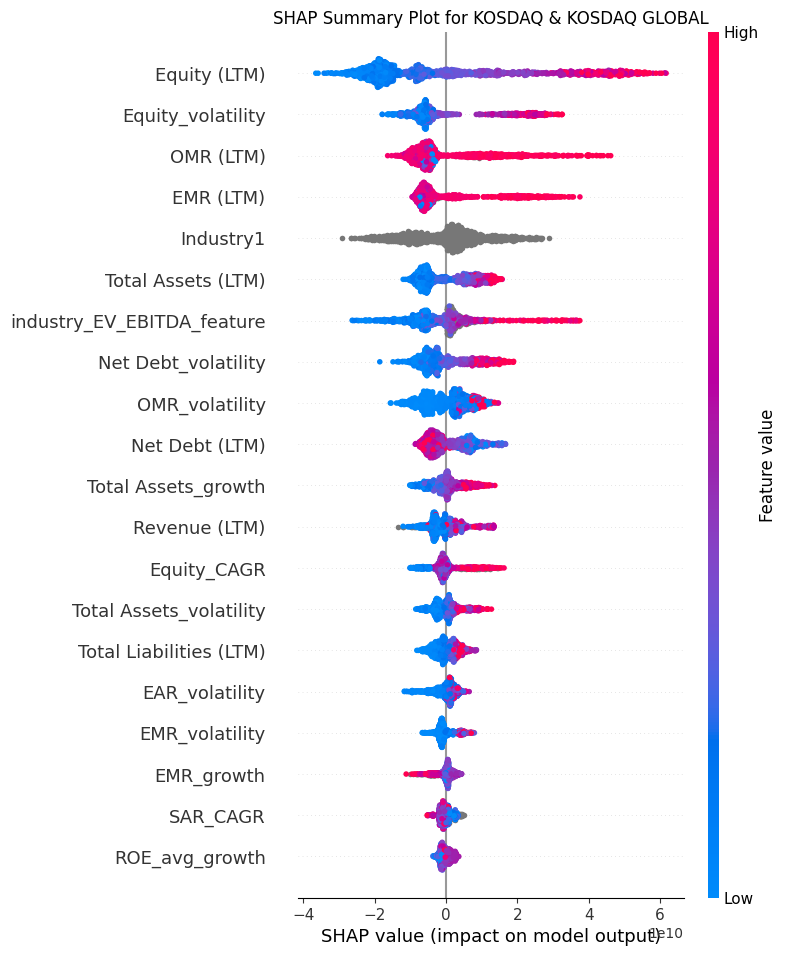


사용 가능한 변수 리스트 (97개):
  Industry1
  Industry2
  Industry3
  Industry4
  Industry5
  Net Debt (LTM)
  Total Liabilities (LTM)
  Total Assets (LTM)
  Equity (LTM)
  Revenue (LTM)
  Net Income (LTM)
  Net Income After Minority (LTM)
  EBIT (LTM)
  Dividends (LTM)
  EBITDA (LTM)
  Listing_Age_Days
  industry_PER_feature
  industry_EV_EBITDA_feature
  Total Assets_growth
  Total Assets_avg_growth
  Total Assets_volatility
  Total Assets_CAGR
  Total Liabilities_growth
  Total Liabilities_avg_growth
  Total Liabilities_volatility
  Total Liabilities_CAGR
  Equity_growth
  Equity_avg_growth
  Equity_volatility
  Equity_CAGR
  Net Debt_growth
  Net Debt_avg_growth
  Net Debt_volatility
  Net Debt_CAGR
  Revenue_growth
  Revenue_avg_growth
  Revenue_volatility
  Revenue_CAGR
  EBIT_growth
  EBIT_avg_growth
  EBIT_volatility
  EBIT_CAGR
  EBITDA_growth
  EBITDA_avg_growth
  EBITDA_volatility
  EBITDA_CAGR
  Net Income_growth
  Net Income_avg_growth
  Net Income_volatility
  Net Income_CAGR
  Net

[I 2025-05-24 09:10:18,006] A new study created in memory with name: no-name-2cce7e8d-1b84-49ac-b10e-31c7d2be9efb



[KOSPI] 선택된 피처 (31개):
  Listing_Age_Days: 188.00
  Dividends_growth: 186.00
  Equity (LTM): 160.00
  Net Income After Minority (LTM): 137.00
  Equity_volatility: 137.00
  Dividends (LTM): 124.00
  Dividends_volatility: 122.00
  Total Assets_volatility: 116.00
  Revenue_volatility: 115.00
  industry_EV_EBITDA_feature: 113.00
  Total Liabilities_volatility: 113.00
  DBR_growth: 111.00
  Equity_growth: 104.00
  Net Debt_volatility: 100.00
  industry_PER_feature: 100.00
  Dividends_avg_growth: 99.00
  Total Liabilities_CAGR: 96.00
  Revenue_growth: 94.00
  EBITDA_volatility: 91.00
  EBIT (LTM): 90.00
  EAR_CAGR: 88.00
  Net Income After Minority_volatility: 86.00
  EBR_CAGR: 85.00
  SAR_growth: 82.00
  Net Income_volatility: 81.00
  Revenue_CAGR: 78.00
  EBIT_volatility: 78.00
  Dividends_CAGR: 76.00
  SAR_volatility: 73.00
  SAR_CAGR: 73.00
  Net Income After Minority_avg_growth: 73.00
  BAR_volatility: 72.00
  Net Income_CAGR: 71.00
  Net Debt_growth: 70.00
  Revenue (LTM): 68.00
  SAR 

[I 2025-05-24 09:10:18,378] Trial 1 finished with value: 304791696026.30145 and parameters: {'learning_rate': 0.28260642209609743, 'num_leaves': 148, 'max_depth': 6, 'min_child_samples': 50, 'subsample': 0.7628273342691646, 'colsample_bytree': 0.9262062938037611, 'reg_alpha': 1.1445198624413204, 'reg_lambda': 6.9088959207407346}. Best is trial 1 with value: 304791696026.30145.
[I 2025-05-24 09:10:18,544] Trial 0 finished with value: 307968165209.3793 and parameters: {'learning_rate': 0.21276612417194213, 'num_leaves': 106, 'max_depth': 15, 'min_child_samples': 72, 'subsample': 0.9133070511431083, 'colsample_bytree': 0.8985679780215904, 'reg_alpha': 2.516277862749796, 'reg_lambda': 0.2892119271234599}. Best is trial 1 with value: 304791696026.30145.
[I 2025-05-24 09:10:18,656] Trial 2 finished with value: 317364244150.76306 and parameters: {'learning_rate': 0.2798877945583082, 'num_leaves': 123, 'max_depth': 11, 'min_child_samples': 92, 'subsample': 0.8145315621449809, 'colsample_bytree


[KOSPI] SHAP Feature Importances (Top 20):


,feature,importance
3,Equity_volatility,1.307856e+11
2,Equity (LTM),1.118031e+11
19,EBIT (LTM),9.140955e+10
4,Net Income After Minority (LTM),8.345535e+10
5,Dividends (LTM),8.331904e+10
14,industry_PER_feature,7.760575e+10
10,Total Liabilities_volatility,4.995280e+10
21,Net Income After Minority_volatility,3.644352e+10
6,Dividends_volatility,3.193795e+10
0,Listing_Age_Days,2.407483e+10



[KOSPI] SHAP Summary Plot (Top 20 Features):


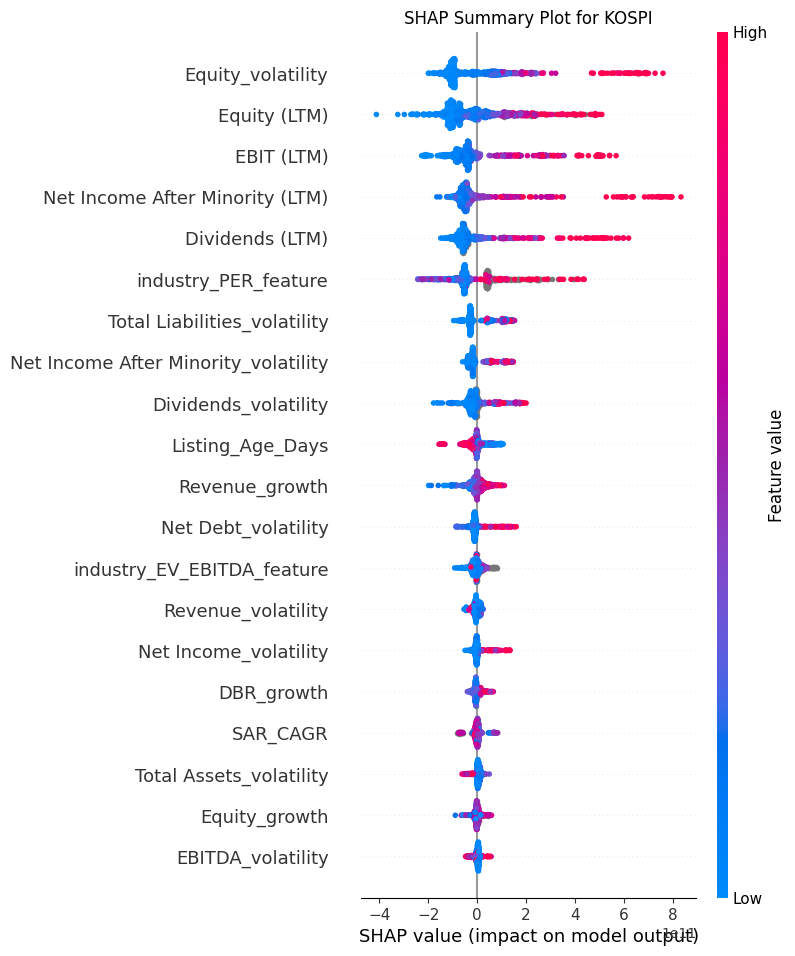

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
import optuna
import shap
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
import re
warnings.filterwarnings("ignore")

# 산업 PER 기반 피처 계산 (IQR 이상치 제거 후 조화평균)
def calculate_industry_per_feature(df):
    """산업별 PER을 계산하며, IQR로 이상치를 제거한 후 조화평균을 적용"""
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    industries = df[industry_cols].stack().dropna().unique()

    harm_means = {}
    for ind in industries:
        mask = df[industry_cols].apply(lambda r: ind in r.values, axis=1)
        sub = df.loc[mask & df['Net Income (LTM)'].gt(0) & df['Net Income (LTM)'].notna()]
        per_vals = sub['market_cap'] / sub['Net Income (LTM)']

        if len(per_vals) > 0:
            q1 = per_vals.quantile(0.25)
            q3 = per_vals.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 2 * iqr
            upper_bound = q3 + 2 * iqr
            per_vals_filtered = per_vals[(per_vals >= lower_bound) & (per_vals <= upper_bound)]
            harm_means[ind] = len(per_vals_filtered) / (1.0 / per_vals_filtered).sum() if len(per_vals_filtered) > 0 else np.nan
        else:
            harm_means[ind] = np.nan

    def feature(row):
        nets = row['Net Income (LTM)']
        if nets <= 0 or pd.isna(nets):
            return np.nan
        inds = [row[c] for c in industry_cols if pd.notna(row[c])]
        hms = [harm_means[i] for i in inds if not np.isnan(harm_means.get(i, np.nan))]
        return np.mean(hms) * nets if hms else np.nan

    return df.apply(feature, axis=1)

# 산업 EV/EBITDA 기반 피처 계산 (IQR 이상치 제거 후 조화평균)
def calculate_industry_EV_EBITDA_feature(df):
    """산업별 EV/EBITDA를 계산하며, IQR로 이상치를 제거한 후 조화평균을 적용"""
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    industries = df[industry_cols].stack().dropna().unique()

    harm_means_ev = {}
    for ind in industries:
        mask = df[industry_cols].apply(lambda r: ind in r.values, axis=1)
        sub = df.loc[mask & df['EBITDA (LTM)'].gt(0) & df['EBITDA (LTM)'].notna() & df['Enterprise Value (FQ0)'].notna()]
        ev_vals = sub['Enterprise Value (FQ0)'] / sub['EBITDA (LTM)']

        if len(ev_vals) > 0:
            q1 = ev_vals.quantile(0.25)
            q3 = ev_vals.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 2 * iqr
            upper_bound = q3 + 2 * iqr
            ev_vals_filtered = ev_vals[(ev_vals >= lower_bound) & (ev_vals <= upper_bound)]
            harm_means_ev[ind] = len(ev_vals_filtered) / (1.0 / ev_vals_filtered).sum() if len(ev_vals_filtered) > 0 else np.nan
        else:
            harm_means_ev[ind] = np.nan

    def feature_ev(row):
        ebitda = row['EBITDA (LTM)']
        if ebitda <= 0 or pd.isna(ebitda):
            return np.nan
        inds = [row[c] for c in industry_cols if pd.notna(row[c])]
        hms = [harm_means_ev[i] for i in inds if not np.isnan(harm_means_ev.get(i, np.nan))]
        return np.mean(hms) * ebitda if hms else np.nan

    return df.apply(feature_ev, axis=1)

# 도메인 및 시간 기반 피처 엔지니어링 클래스
class DomainFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        Xt = self._transform(X.copy())
        self.cols_ = Xt.columns.tolist()
        print(f"\n사용 가능한 변수 리스트 ({len(self.cols_)}개):")
        for col in self.cols_:
            print(f"  {col}")
        return self

    def transform(self, X):
        Xt = self._transform(X.copy())
        return Xt.reindex(columns=self.cols_, fill_value=0)

    def _transform(self, X):
        X = X.drop('market', axis=1, errors='ignore')
        tcols = [c for c in X.columns if '(' in c and 'LTM' in c]
        tf = {}
        for c in tcols:
            base, per = c.split(' (')
            tf.setdefault(base, {})[per.rstrip(')')] = c

        if 'EBIT' in tf and 'Depreciation' in tf:
            for p, e in tf['EBIT'].items():
                d = tf['Depreciation'].get(p)
                if d:
                    X[f'EBITDA ({p})'] = X[e] + X[d]
            tf['EBITDA'] = {p: f'EBITDA ({p})' for p in tf['EBIT']}

        bases = ['Total Assets', 'Total Liabilities', 'Equity', 'Net Debt',
                 'Revenue', 'EBIT', 'EBITDA', 'Net Income', 'Net Income After Minority', 'Dividends']

        def safe_div(a, b):
            return a.div(b.replace({0: np.nan}))

        for v in bases:
            periods = tf.get(v, {})
            seq = [p for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if p in periods]
            grs = []
            for i in range(1, len(seq)):
                prev, curr = seq[i-1], seq[i]
                r = safe_div(X[periods[curr]] - X[periods[prev]], X[periods[prev]])
                suffix = '-2' if (prev, curr) == ('LTM-3', 'LTM-2') else '-1' if (prev, curr) == ('LTM-2', 'LTM-1') else ''
                X[f'{v}_growth{suffix}'] = r
                grs.append(r)
            if grs:
                X[f'{v}_avg_growth'] = pd.concat(grs, axis=1).mean(axis=1)
                X[f'{v}_volatility'] = X[[periods[p] for p in seq]].std(axis=1)
            if 'LTM-3' in periods and 'LTM' in periods:
                X[f'{v}_CAGR'] = np.where(
                    X[periods['LTM-3']] > 0,
                    (X[periods['LTM']] / X[periods['LTM-3']])**(1/3) - 1,
                    np.nan
                )

        def calc(a, b, name, per):
            if per in tf.get(a, {}) and per in tf.get(b, {}):
                X[f'{name} ({per})'] = safe_div(X[tf[a][per]], X[tf[b][per]])

        ratios = [
            ('Equity', 'Total Assets', 'BAR'),
            ('Total Liabilities', 'Equity', 'DBR'),
            ('Revenue', 'Total Assets', 'SAR'),
            ('EBIT', 'Revenue', 'OMR'),
            ('EBITDA', 'Revenue', 'EMR'),
            ('Net Income', 'Total Assets', 'EAR'),
            ('Net Income', 'Equity', 'EBR')
        ]
        for p in ['LTM', 'LTM-1', 'LTM-2', 'LTM-3']:
            for a, b, n in ratios:
                calc(a, b, n, p)
            if p in ['LTM-2', 'LTM-1', 'LTM']:
                ni = tf.get('Net Income After Minority', {}).get(p)
                eq = tf.get('Equity', {}).get(p)
                prev = {'LTM-2': 'LTM-3', 'LTM-1': 'LTM-2', 'LTM': 'LTM-1'}[p]
                ep = tf.get('Equity', {}).get(prev)
                if ni and eq and ep:
                    avg_eq = (X[eq] + X[ep]) / 2
                    X[f'ROE ({p})'] = safe_div(X[ni], avg_eq)

        ratio_bases = ['BAR', 'DBR', 'SAR', 'OMR', 'EMR', 'EAR', 'EBR', 'ROE']
        for v in ratio_bases:
            periods = {p: f'{v} ({p})' for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if f'{v} ({p})' in X.columns}
            seq = [p for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if p in periods]
            grs = []
            for i in range(1, len(seq)):
                prev, curr = seq[i-1], seq[i]
                r = safe_div(X[periods[curr]] - X[periods[prev]], X[periods[prev]])
                suffix = '-2' if (prev, curr) == ('LTM-3', 'LTM-2') else '-1' if (prev, curr) == ('LTM-2', 'LTM-1') else ''
                X[f'{v}_growth{suffix}'] = r
                grs.append(r)
            if grs:
                X[f'{v}_avg_growth'] = pd.concat(grs, axis=1).mean(axis=1)
                X[f'{v}_volatility'] = X[[periods[p] for p in seq]].std(axis=1)
            if 'LTM-3' in periods and 'LTM' in periods:
                X[f'{v}_CAGR'] = np.where(
                    X[periods['LTM-3']] > 0,
                    (X[periods['LTM']] / X[periods['LTM-3']])**(1/3) - 1,
                    np.nan
                )

        dep_cols = [c for c in X.columns if c.startswith('Depreciation')]
        if dep_cols:
            X.drop(columns=dep_cols, inplace=True)

        industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
        for col in industry_cols:
            if col in X.columns:
                X[col] = X[col].astype('category')

        exclude_cols = [col for col in X.columns if re.search(r'\(LTM-\d+\)$|_growth-\d+$', col)]
        X = X.drop(columns=exclude_cols)

        return X

# LightGBM 하이퍼파라미터 최적화 (0.5 quantile)
def optimize_lightgbm(X, y, n_trials=50):
    """LightGBM 모델의 하이퍼파라미터를 최적화하며 0.5 quantile loss를 최소화"""
    def objective(trial):
        param = {
            'objective': 'quantile',
            'alpha': 0.5,
            'n_estimators': 1000,  # Large number, early stopping will adjust
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        val_losses = []
        cat_cols = [col for col in ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5'] if col in X.columns]

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = LGBMRegressor(**param)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='quantile',
                callbacks=[early_stopping(stopping_rounds=10, verbose=False)],
                categorical_feature=cat_cols
            )
            y_pred = model.predict(X_val)
            loss = np.mean(np.where(y_val >= y_pred, 0.5 * (y_val - y_pred), 0.5 * (y_pred - y_val)))
            val_losses.append(loss)

        return np.mean(val_losses)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)
    best_params = study.best_params
    best_params.update({
        'objective': 'quantile',
        'alpha': 0.5,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    })
    return best_params

# LightGBM 0.5 quantile 모델 실행 및 SHAP 분석
def quick_lightgbm_quantile(df, name):
    """LightGBM 0.5 quantile 모델을 실행하고 SHAP 피처 중요도를 계산 및 시각화"""
    df = df.copy()

    # EBITDA 생성
    if 'EBITDA (LTM)' not in df and 'EBIT (LTM)' in df and 'Depreciation (LTM)' in df:
        df['EBITDA (LTM)'] = df['EBIT (LTM)'] + df['Depreciation (LTM)']

    # 상장일 변환
    df['Listing_Age_Days'] = (pd.to_datetime('2024-12-31') - pd.to_datetime(df['Listing Date'])).dt.days
    df.drop(columns=['Listing Date'], inplace=True)

    # 산업 피처 계산
    df['industry_PER_feature'] = calculate_industry_per_feature(df)
    df['industry_EV_EBITDA_feature'] = calculate_industry_EV_EBITDA_feature(df)

    # 카테고리 변수 설정
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    for col in industry_cols:
        if col in df:
            df[col] = df[col].astype('category')

    # 설명 변수 선택
    X = df.select_dtypes(include=[np.number, 'category']).drop(
        columns=['Market Cap (2024-12-31)', 'market_cap', 'Enterprise Value (FQ0)'], errors='ignore')
    y = df['market_cap']

    # 피처 엔지니어링
    fe = DomainFeatureEngineer().fit(X, y)
    X_fe = fe.transform(X)

    # 피처 선택
    selector = LGBMRegressor(n_estimators=200, random_state=42)
    selector.fit(X_fe, y)
    imp = pd.Series(selector.feature_importances_, index=X_fe.columns)
    selected = imp[imp > imp.mean() * 1.2].sort_values(ascending=False).index.tolist()

    print(f"\n[{name}] 선택된 피처 ({len(selected)}개):")
    for feat, score in imp[imp > imp.mean()].sort_values(ascending=False).items():
        print(f"  {feat}: {score:.2f}")

    # 모델 최적화 및 학습
    X_sel = X_fe[selected]
    best_params = optimize_lightgbm(X_sel, y)
    cat_cols = [col for col in industry_cols if col in X_sel.columns]

    model = LGBMRegressor(**best_params)
    model.fit(X_sel, y, categorical_feature=cat_cols)

    # SHAP 값 계산
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sel)

    # 피처 중요도 계산 및 표 출력
    shap_importances = np.abs(shap_values).mean(axis=0)
    feature_importance_df = pd.DataFrame({
        'feature': X_sel.columns,
        'importance': shap_importances
    }).sort_values(by='importance', ascending=False)

    print(f"\n[{name}] SHAP Feature Importances (Top 20):")
    display(feature_importance_df.head(20))

    # SHAP Summary Plot (Beeswarm)
    print(f"\n[{name}] SHAP Summary Plot (Top 20 Features):")
    shap.summary_plot(shap_values, X_sel, max_display=20, show=False)
    plt.title(f"SHAP Summary Plot for {name}")
    display(plt.gcf())
    plt.close()

    return feature_importance_df

# 메인 실행
if __name__ == "__main__":
    PATH = "/content/5_7_데이터.xlsx"
    df = pd.read_excel(PATH, sheet_name="Sheet1")

    # 데이터 전처리
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    for col in industry_cols:
        if col in df:
            df[col] = df[col].astype('category')

    df = df[df["market"].isin(["KOSDAQ", "KOSDAQ GLOBAL", "KOSPI"]) & (df["Market Cap (2024-12-31)"] > 0)]
    df["market_cap"] = df["Market Cap (2024-12-31)"]

    exclude_tickers = set(['003380', '005290', '005990', '006730', '007330', '012700', '013120', '013310', '015750', '016250',
                           '018310', '019210', '021320', '023410', '023760', '025900', '025980', '027710', '028300', '030530',
                           '031330', '032190', '033160', '033290', '033640', '034810', '035080', '035600', '035760', '035810',
                           '035890', '035900', '036710', '036800', '036830', '036930', '037460', '038110', '038390', '038500',
                           '038540', '041190', '041510', '043370', '046890', '049070', '051500', '053700', '056190', '058470',
                           '061970', '064760', '064820', '067160', '067170', '067310', '067570', '067990', '069080', '071460',
                           '074600', '078020', '078340', '080420', '084110', '084850', '085660', '086520', '091700', '092190',
                           '096530', '100790', '101330', '104480', '112040', '115160', '121440', '122450', '122690', '123040',
                           '124500', '131970', '136480', '137400', '141080', '145020', '151860', '178320', '195940', '205470',
                           '214450', '215000', '215200', '222800', '240810', '247540', '253450', '263750', '267980', '293490',
                           '348370', '357780', '393890', '403870', '900290', '950130', '000270', '000660', '000810', '000880',
                           '001040', '003490', '003550', '004020', '005380', '005490', '005830', '005930', '005940', '006400',
                           '006800', '009540', '010950', '011170', '011200', '012330', '015760', '016360', '017670', '023530',
                           '023590', '024110', '028260', '030200', '032830', '034220', '034730', '035420', '035720', '036460',
                           '042660', '051910', '055550', '066570', '071050', '078930', '086790', '088350', '096770', '097950',
                           '105560', '138040', '138930', '139130', '139480', '207940', '267250', '316140', '373220', '402340',
                           '415640'])
    df = df[~df['ticker'].isin(exclude_tickers)].reset_index(drop=True)

    num_cols = df.select_dtypes(include=[np.number]).columns
    df = df[df[num_cols].isnull().mean(axis=1) <= 0.5].reset_index(drop=True)

    # 시장별 데이터 분리 및 모델 실행
    kosdaq = df[df["market"].isin(["KOSDAQ", "KOSDAQ GLOBAL"])]
    kospi = df[df["market"] == "KOSPI"]

    res1 = quick_lightgbm_quantile(kosdaq, "KOSDAQ & KOSDAQ GLOBAL")
    res2 = quick_lightgbm_quantile(kospi, "KOSPI")


사용 가능한 변수 리스트 (79개):
  Industry1
  Industry2
  Industry3
  Industry4
  Industry5
  Net Debt (LTM)
  Total Liabilities (LTM)
  Total Assets (LTM)
  Equity (LTM)
  Revenue (LTM)
  Net Income (LTM)
  Net Income After Minority (LTM)
  EBIT (LTM)
  Dividends (LTM)
  EBITDA (LTM)
  Listing_Age_Days
  industry_PER_feature
  industry_EV_EBITDA_feature
  Total Assets_growth
  Total Assets_avg_growth
  Total Assets_CAGR
  Total Liabilities_growth
  Total Liabilities_avg_growth
  Total Liabilities_CAGR
  Equity_growth
  Equity_avg_growth
  Equity_CAGR
  Net Debt_growth
  Net Debt_avg_growth
  Net Debt_CAGR
  Revenue_growth
  Revenue_avg_growth
  Revenue_CAGR
  EBIT_growth
  EBIT_avg_growth
  EBIT_CAGR
  EBITDA_growth
  EBITDA_avg_growth
  EBITDA_CAGR
  Net Income_growth
  Net Income_avg_growth
  Net Income_CAGR
  Net Income After Minority_growth
  Net Income After Minority_avg_growth
  Net Income After Minority_CAGR
  Dividends_growth
  Dividends_avg_growth
  Dividends_CAGR
  BAR (LTM)
  DBR (LT

[I 2025-05-24 09:20:06,471] A new study created in memory with name: no-name-0757ed38-e3d1-4ac4-a05c-cf061183a706



[KOSDAQ & KOSDAQ GLOBAL] 선택된 피처 (22개):
  SAR_CAGR: 261.00
  Equity (LTM): 244.00
  Revenue_CAGR: 231.00
  EMR_growth: 227.00
  Total Assets (LTM): 215.00
  EBITDA (LTM): 163.00
  SAR (LTM): 156.00
  Total Liabilities (LTM): 153.00
  Revenue (LTM): 149.00
  Net Debt_growth: 142.00
  Net Debt (LTM): 140.00
  Revenue_avg_growth: 125.00
  Industry1: 123.00
  Equity_CAGR: 114.00
  EBIT (LTM): 110.00
  Total Assets_growth: 109.00
  OMR (LTM): 109.00
  SAR_growth: 105.00
  EBR_growth: 97.00
  EMR (LTM): 95.00
  SAR_avg_growth: 93.00
  Net Income After Minority_avg_growth: 92.00
  EBITDA_growth: 91.00
  Revenue_growth: 90.00
  Dividends (LTM): 90.00
  ROE_avg_growth: 90.00
  Dividends_growth: 88.00
  industry_EV_EBITDA_feature: 87.00
  Net Income_growth: 77.00


[I 2025-05-24 09:20:08,421] Trial 0 finished with value: 50806361442.23126 and parameters: {'learning_rate': 0.031284819645933375, 'num_leaves': 137, 'max_depth': 10, 'min_child_samples': 89, 'subsample': 0.8701911738844045, 'colsample_bytree': 0.6336485159434032, 'reg_alpha': 2.878925520871393, 'reg_lambda': 0.12215053170092982}. Best is trial 0 with value: 50806361442.23126.
[I 2025-05-24 09:20:09,340] Trial 1 finished with value: 50448170420.425644 and parameters: {'learning_rate': 0.03599240390341537, 'num_leaves': 93, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.6855888257210896, 'colsample_bytree': 0.8679071843392714, 'reg_alpha': 4.461398880405118, 'reg_lambda': 5.53846488710323}. Best is trial 1 with value: 50448170420.425644.
[I 2025-05-24 09:20:10,340] Trial 3 finished with value: 50670031038.781425 and parameters: {'learning_rate': 0.10512951453643372, 'num_leaves': 143, 'max_depth': 9, 'min_child_samples': 55, 'subsample': 0.7648343035201317, 'colsample_bytree': 


[KOSDAQ & KOSDAQ GLOBAL] SHAP Feature Importances (Top 20):


,feature,importance
1,Equity (LTM),2.803330e+10
5,EBITDA (LTM),8.454014e+09
12,Industry1,8.285168e+09
14,EBIT (LTM),8.156507e+09
13,Equity_CAGR,7.936382e+09
19,EMR (LTM),6.189231e+09
4,Total Assets (LTM),4.441292e+09
16,OMR (LTM),4.428159e+09
15,Total Assets_growth,4.365812e+09
10,Net Debt (LTM),4.105533e+09



[KOSDAQ & KOSDAQ GLOBAL] SHAP Summary Plot (Top 20 Features):


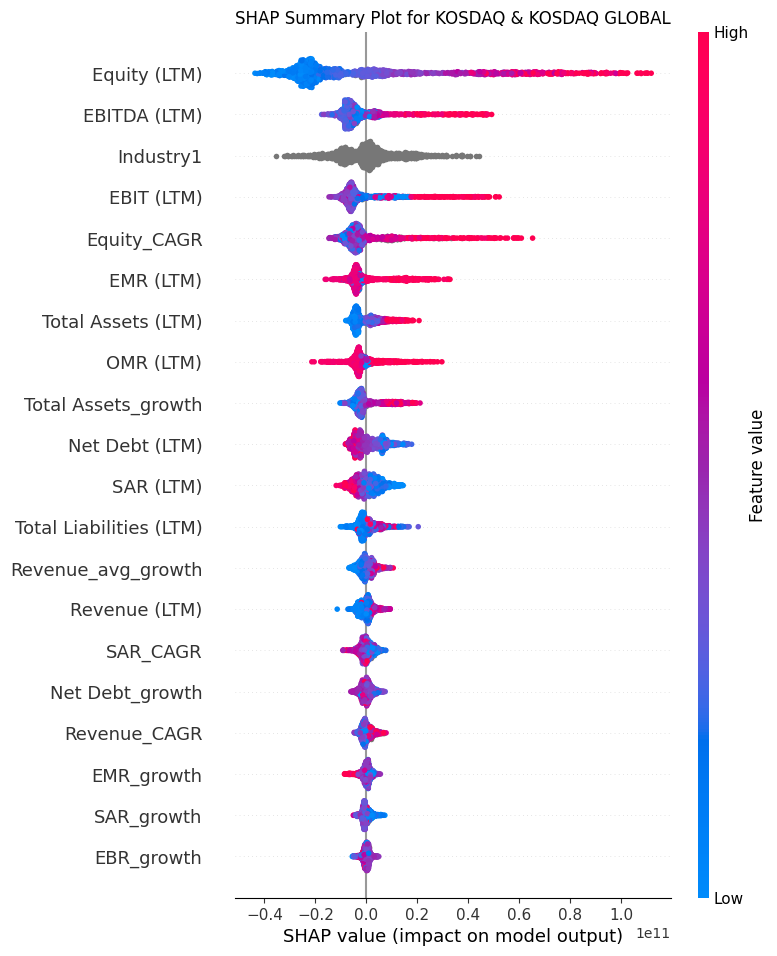


사용 가능한 변수 리스트 (79개):
  Industry1
  Industry2
  Industry3
  Industry4
  Industry5
  Net Debt (LTM)
  Total Liabilities (LTM)
  Total Assets (LTM)
  Equity (LTM)
  Revenue (LTM)
  Net Income (LTM)
  Net Income After Minority (LTM)
  EBIT (LTM)
  Dividends (LTM)
  EBITDA (LTM)
  Listing_Age_Days
  industry_PER_feature
  industry_EV_EBITDA_feature
  Total Assets_growth
  Total Assets_avg_growth
  Total Assets_CAGR
  Total Liabilities_growth
  Total Liabilities_avg_growth
  Total Liabilities_CAGR
  Equity_growth
  Equity_avg_growth
  Equity_CAGR
  Net Debt_growth
  Net Debt_avg_growth
  Net Debt_CAGR
  Revenue_growth
  Revenue_avg_growth
  Revenue_CAGR
  EBIT_growth
  EBIT_avg_growth
  EBIT_CAGR
  EBITDA_growth
  EBITDA_avg_growth
  EBITDA_CAGR
  Net Income_growth
  Net Income_avg_growth
  Net Income_CAGR
  Net Income After Minority_growth
  Net Income After Minority_avg_growth
  Net Income After Minority_CAGR
  Dividends_growth
  Dividends_avg_growth
  Dividends_CAGR
  BAR (LTM)
  DBR (LT

[I 2025-05-24 09:21:05,851] A new study created in memory with name: no-name-6f665a67-1715-443a-a7e0-8a4d321bdbe5



[KOSPI] 선택된 피처 (22개):
  Equity (LTM): 266.00
  Listing_Age_Days: 221.00
  Net Income After Minority (LTM): 191.00
  Dividends_growth: 191.00
  Revenue (LTM): 178.00
  Total Assets (LTM): 147.00
  Dividends (LTM): 144.00
  EBIT (LTM): 143.00
  Revenue_CAGR: 136.00
  Total Liabilities_CAGR: 126.00
  industry_PER_feature: 124.00
  industry_EV_EBITDA_feature: 120.00
  Revenue_growth: 119.00
  Dividends_avg_growth: 117.00
  SAR_CAGR: 105.00
  Equity_growth: 104.00
  Net Debt (LTM): 99.00
  DBR_growth: 99.00
  SAR_growth: 99.00
  Net Income After Minority_avg_growth: 99.00
  EBR_CAGR: 95.00
  Net Debt_growth: 92.00
  Revenue_avg_growth: 88.00
  Net Debt_avg_growth: 86.00
  EAR_CAGR: 86.00
  Net Income (LTM): 85.00
  Total Liabilities (LTM): 85.00
  Dividends_CAGR: 85.00
  EMR_avg_growth: 76.00


[I 2025-05-24 09:21:06,399] Trial 0 finished with value: 311544827253.0934 and parameters: {'learning_rate': 0.1683640623548349, 'num_leaves': 129, 'max_depth': 11, 'min_child_samples': 72, 'subsample': 0.9442817954008598, 'colsample_bytree': 0.9911056983907719, 'reg_alpha': 3.483519874105504, 'reg_lambda': 1.9110726674576588}. Best is trial 0 with value: 311544827253.0934.
[I 2025-05-24 09:21:06,518] Trial 1 finished with value: 307813796507.4618 and parameters: {'learning_rate': 0.09780195997014782, 'num_leaves': 51, 'max_depth': 7, 'min_child_samples': 47, 'subsample': 0.7294956594760735, 'colsample_bytree': 0.9310818129285633, 'reg_alpha': 5.510266309256579, 'reg_lambda': 4.901450351932386}. Best is trial 1 with value: 307813796507.4618.
[I 2025-05-24 09:21:07,012] Trial 2 finished with value: 311256246113.32776 and parameters: {'learning_rate': 0.19291043932257038, 'num_leaves': 66, 'max_depth': 9, 'min_child_samples': 67, 'subsample': 0.964688596989029, 'colsample_bytree': 0.6793


[KOSPI] SHAP Feature Importances (Top 20):


,feature,importance
0,Equity (LTM),1.795270e+11
7,EBIT (LTM),1.655625e+11
6,Dividends (LTM),1.317310e+11
3,Net Income After Minority (LTM),9.613257e+10
10,industry_PER_feature,4.879284e+10
1,Listing_Age_Days,4.823607e+10
5,Total Assets (LTM),3.931149e+10
12,Revenue_growth,3.745410e+10
4,Revenue (LTM),3.188069e+10
21,Net Debt_growth,2.819983e+10



[KOSPI] SHAP Summary Plot (Top 20 Features):


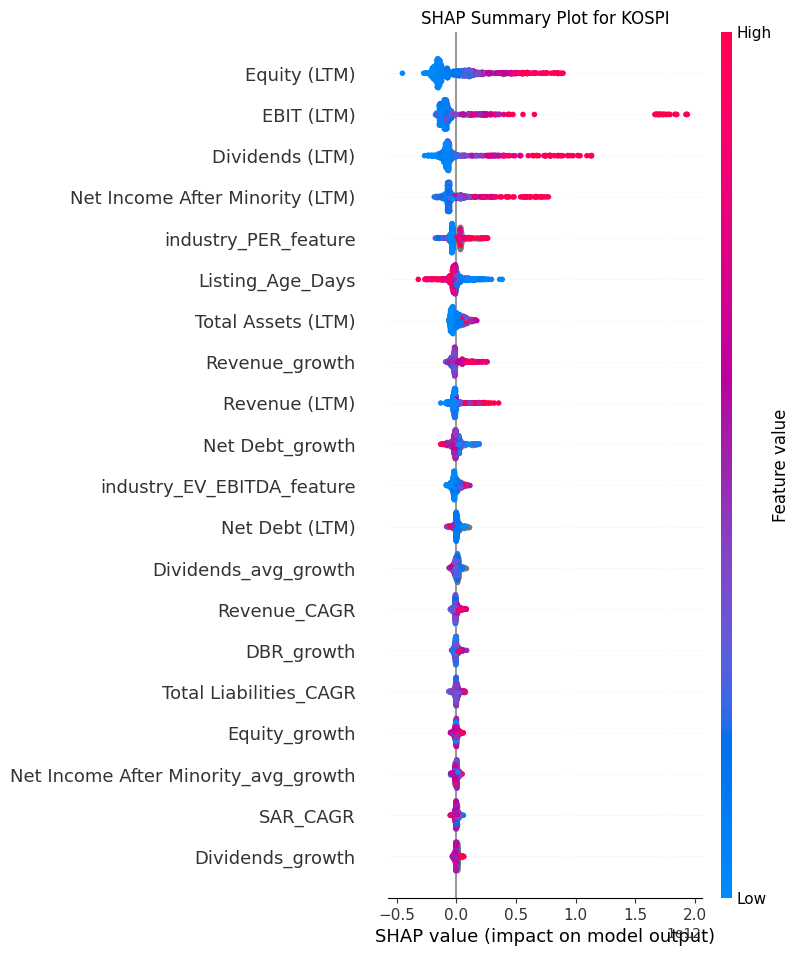

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
import optuna
import shap
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
import re
warnings.filterwarnings("ignore")

# 산업 PER 기반 피처 계산 (IQR 이상치 제거 후 조화평균)
def calculate_industry_per_feature(df):
    """산업별 PER을 계산하며, IQR로 이상치를 제거한 후 조화평균을 적용"""
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    industries = df[industry_cols].stack().dropna().unique()

    harm_means = {}
    for ind in industries:
        mask = df[industry_cols].apply(lambda r: ind in r.values, axis=1)
        sub = df.loc[mask & df['Net Income (LTM)'].gt(0) & df['Net Income (LTM)'].notna()]
        per_vals = sub['market_cap'] / sub['Net Income (LTM)']

        if len(per_vals) > 0:
            q1 = per_vals.quantile(0.25)
            q3 = per_vals.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 2 * iqr
            upper_bound = q3 + 2 * iqr
            per_vals_filtered = per_vals[(per_vals >= lower_bound) & (per_vals <= upper_bound)]
            harm_means[ind] = len(per_vals_filtered) / (1.0 / per_vals_filtered).sum() if len(per_vals_filtered) > 0 else np.nan
        else:
            harm_means[ind] = np.nan

    def feature(row):
        nets = row['Net Income (LTM)']
        if nets <= 0 or pd.isna(nets):
            return np.nan
        inds = [row[c] for c in industry_cols if pd.notna(row[c])]
        hms = [harm_means[i] for i in inds if not np.isnan(harm_means.get(i, np.nan))]
        return np.mean(hms) * nets if hms else np.nan

    return df.apply(feature, axis=1)

# 산업 EV/EBITDA 기반 피처 계산 (IQR 이상치 제거 후 조화평균)
def calculate_industry_EV_EBITDA_feature(df):
    """산업별 EV/EBITDA를 계산하며, IQR로 이상치를 제거한 후 조화평균을 적용"""
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    industries = df[industry_cols].stack().dropna().unique()

    harm_means_ev = {}
    for ind in industries:
        mask = df[industry_cols].apply(lambda r: ind in r.values, axis=1)
        sub = df.loc[mask & df['EBITDA (LTM)'].gt(0) & df['EBITDA (LTM)'].notna() & df['Enterprise Value (FQ0)'].notna()]
        ev_vals = sub['Enterprise Value (FQ0)'] / sub['EBITDA (LTM)']

        if len(ev_vals) > 0:
            q1 = ev_vals.quantile(0.25)
            q3 = ev_vals.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 2 * iqr
            upper_bound = q3 + 2 * iqr
            ev_vals_filtered = ev_vals[(ev_vals >= lower_bound) & (ev_vals <= upper_bound)]
            harm_means_ev[ind] = len(ev_vals_filtered) / (1.0 / ev_vals_filtered).sum() if len(ev_vals_filtered) > 0 else np.nan
        else:
            harm_means_ev[ind] = np.nan

    def feature_ev(row):
        ebitda = row['EBITDA (LTM)']
        if ebitda <= 0 or pd.isna(ebitda):
            return np.nan
        inds = [row[c] for c in industry_cols if pd.notna(row[c])]
        hms = [harm_means_ev[i] for i in inds if not np.isnan(harm_means_ev.get(i, np.nan))]
        return np.mean(hms) * ebitda if hms else np.nan

    return df.apply(feature_ev, axis=1)

# 도메인 및 시간 기반 피처 엔지니어링 클래스
class DomainFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        Xt = self._transform(X.copy())
        self.cols_ = Xt.columns.tolist()
        print(f"\n사용 가능한 변수 리스트 ({len(self.cols_)}개):")
        for col in self.cols_:
            print(f"  {col}")
        return self

    def transform(self, X):
        Xt = self._transform(X.copy())
        return Xt.reindex(columns=self.cols_, fill_value=0)

    def _transform(self, X):
        X = X.drop('market', axis=1, errors='ignore')
        tcols = [c for c in X.columns if '(' in c and 'LTM' in c]
        tf = {}
        for c in tcols:
            base, per = c.split(' (')
            tf.setdefault(base, {})[per.rstrip(')')] = c

        if 'EBIT' in tf and 'Depreciation' in tf:
            for p, e in tf['EBIT'].items():
                d = tf['Depreciation'].get(p)
                if d:
                    X[f'EBITDA ({p})'] = X[e] + X[d]
            tf['EBITDA'] = {p: f'EBITDA ({p})' for p in tf['EBIT']}

        bases = ['Total Assets', 'Total Liabilities', 'Equity', 'Net Debt',
                 'Revenue', 'EBIT', 'EBITDA', 'Net Income', 'Net Income After Minority', 'Dividends']

        def safe_div(a, b):
            return a.div(b.replace({0: np.nan}))

        for v in bases:
            periods = tf.get(v, {})
            seq = [p for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if p in periods]
            grs = []
            for i in range(1, len(seq)):
                prev, curr = seq[i-1], seq[i]
                r = safe_div(X[periods[curr]] - X[periods[prev]], X[periods[prev]])
                suffix = '-2' if (prev, curr) == ('LTM-3', 'LTM-2') else '-1' if (prev, curr) == ('LTM-2', 'LTM-1') else ''
                X[f'{v}_growth{suffix}'] = r
                grs.append(r)
            if grs:
                X[f'{v}_avg_growth'] = pd.concat(grs, axis=1).mean(axis=1)
            if 'LTM-3' in periods and 'LTM' in periods:
                X[f'{v}_CAGR'] = np.where(
                    X[periods['LTM-3']] > 0,
                    (X[periods['LTM']] / X[periods['LTM-3']])**(1/3) - 1,
                    np.nan
                )

        def calc(a, b, name, per):
            if per in tf.get(a, {}) and per in tf.get(b, {}):
                X[f'{name} ({per})'] = safe_div(X[tf[a][per]], X[tf[b][per]])

        ratios = [
            ('Equity', 'Total Assets', 'BAR'),
            ('Total Liabilities', 'Equity', 'DBR'),
            ('Revenue', 'Total Assets', 'SAR'),
            ('EBIT', 'Revenue', 'OMR'),
            ('EBITDA', 'Revenue', 'EMR'),
            ('Net Income', 'Total Assets', 'EAR'),
            ('Net Income', 'Equity', 'EBR')
        ]
        for p in ['LTM', 'LTM-1', 'LTM-2', 'LTM-3']:
            for a, b, n in ratios:
                calc(a, b, n, p)
            if p in ['LTM-2', 'LTM-1', 'LTM']:
                ni = tf.get('Net Income After Minority', {}).get(p)
                eq = tf.get('Equity', {}).get(p)
                prev = {'LTM-2': 'LTM-3', 'LTM-1': 'LTM-2', 'LTM': 'LTM-1'}[p]
                ep = tf.get('Equity', {}).get(prev)
                if ni and eq and ep:
                    avg_eq = (X[eq] + X[ep]) / 2
                    X[f'ROE ({p})'] = safe_div(X[ni], avg_eq)

        ratio_bases = ['BAR', 'DBR', 'SAR', 'OMR', 'EMR', 'EAR', 'EBR', 'ROE']
        for v in ratio_bases:
            periods = {p: f'{v} ({p})' for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if f'{v} ({p})' in X.columns}
            seq = [p for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if p in periods]
            grs = []
            for i in range(1, len(seq)):
                prev, curr = seq[i-1], seq[i]
                r = safe_div(X[periods[curr]] - X[periods[prev]], X[periods[prev]])
                suffix = '-2' if (prev, curr) == ('LTM-3', 'LTM-2') else '-1' if (prev, curr) == ('LTM-2', 'LTM-1') else ''
                X[f'{v}_growth{suffix}'] = r
                grs.append(r)
            if grs:
                X[f'{v}_avg_growth'] = pd.concat(grs, axis=1).mean(axis=1)
            if 'LTM-3' in periods and 'LTM' in periods:
                X[f'{v}_CAGR'] = np.where(
                    X[periods['LTM-3']] > 0,
                    (X[periods['LTM']] / X[periods['LTM-3']])**(1/3) - 1,
                    np.nan
                )

        dep_cols = [c for c in X.columns if c.startswith('Depreciation')]
        if dep_cols:
            X.drop(columns=dep_cols, inplace=True)

        industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
        for col in industry_cols:
            if col in X.columns:
                X[col] = X[col].astype('category')

        exclude_cols = [col for col in X.columns if re.search(r'\(LTM-\d+\)$|_growth-\d+$', col)]
        X = X.drop(columns=exclude_cols)

        return X

# LightGBM 하이퍼파라미터 최적화 (MAPE)
def optimize_lightgbm(X, y, n_trials=50):
    """LightGBM 모델의 하이퍼파라미터를 최적화하며 MAPE를 최소화"""
    def objective(trial):
        param = {
            'objective': 'quantile',
            'alpha': 0.5,
            'n_estimators': 1000,  # Large number, early stopping will adjust
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        val_mapes = []
        cat_cols = [col for col in ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5'] if col in X.columns]

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = LGBMRegressor(**param)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='quantile',
                callbacks=[early_stopping(stopping_rounds=10, verbose=False)],
                categorical_feature=cat_cols
            )
            y_pred = model.predict(X_val)
            # MAPE 계산: |actual - predicted| / |actual| for non-zero actual values
            mask = y_val != 0
            mape = np.mean(np.abs((y_val[mask] - y_pred[mask]) / y_val[mask])) if mask.sum() > 0 else np.inf
            val_mapes.append(mape)

        return np.mean(val_mapes)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)
    best_params = study.best_params
    best_params.update({
        'objective': 'quantile',
        'alpha': 0.5,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    })
    return best_params

# LightGBM 0.5 quantile 모델 실행 및 SHAP 분석
def quick_lightgbm_quantile(df, name):
    """LightGBM 0.5 quantile 모델을 실행하고 SHAP 피처 중요도를 계산 및 시각화"""
    df = df.copy()

    # EBITDA 생성
    if 'EBITDA (LTM)' not in df and 'EBIT (LTM)' in df and 'Depreciation (LTM)' in df:
        df['EBITDA (LTM)'] = df['EBIT (LTM)'] + df['Depreciation (LTM)']

    # 상장일 변환
    df['Listing_Age_Days'] = (pd.to_datetime('2024-12-31') - pd.to_datetime(df['Listing Date'])).dt.days
    df.drop(columns=['Listing Date'], inplace=True)

    # 산업 피처 계산
    df['industry_PER_feature'] = calculate_industry_per_feature(df)
    df['industry_EV_EBITDA_feature'] = calculate_industry_EV_EBITDA_feature(df)

    # 카테고리 변수 설정
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    for col in industry_cols:
        if col in df:
            df[col] = df[col].astype('category')

    # 설명 변수 선택
    X = df.select_dtypes(include=[np.number, 'category']).drop(
        columns=['Market Cap (2024-12-31)', 'market_cap', 'Enterprise Value (FQ0)'], errors='ignore')
    y = df['market_cap']

    # 피처 엔지니어링
    fe = DomainFeatureEngineer().fit(X, y)
    X_fe = fe.transform(X)

    # 피처 선택
    selector = LGBMRegressor(n_estimators=200, random_state=42)
    selector.fit(X_fe, y)
    imp = pd.Series(selector.feature_importances_, index=X_fe.columns)
    selected = imp[imp > imp.mean() * 1.2].sort_values(ascending=False).index.tolist()

    print(f"\n[{name}] 선택된 피처 ({len(selected)}개):")
    for feat, score in imp[imp > imp.mean()].sort_values(ascending=False).items():
        print(f"  {feat}: {score:.2f}")

    # 모델 최적화 및 학습
    X_sel = X_fe[selected]
    best_params = optimize_lightgbm(X_sel, y)
    cat_cols = [col for col in industry_cols if col in X_sel.columns]

    model = LGBMRegressor(**best_params)
    model.fit(X_sel, y, categorical_feature=cat_cols)

    # SHAP 값 계산
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sel)

    # 피처 중요도 계산 및 표 출력
    shap_importances = np.abs(shap_values).mean(axis=0)
    feature_importance_df = pd.DataFrame({
        'feature': X_sel.columns,
        'importance': shap_importances
    }).sort_values(by='importance', ascending=False)

    print(f"\n[{name}] SHAP Feature Importances (Top 20):")
    display(feature_importance_df.head(20))

    # SHAP Summary Plot (Beeswarm)
    print(f"\n[{name}] SHAP Summary Plot (Top 20 Features):")
    shap.summary_plot(shap_values, X_sel, max_display=20, show=False)
    plt.title(f"SHAP Summary Plot for {name}")
    display(plt.gcf())
    plt.close()

    return feature_importance_df

# 메인 실행
if __name__ == "__main__":
    PATH = "/content/5_7_데이터.xlsx"
    df = pd.read_excel(PATH, sheet_name="Sheet1")

    # 데이터 전처리
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    for col in industry_cols:
        if col in df:
            df[col] = df[col].astype('category')

    df = df[df["market"].isin(["KOSDAQ", "KOSDAQ GLOBAL", "KOSPI"]) & (df["Market Cap (2024-12-31)"] > 0)]
    df["market_cap"] = df["Market Cap (2024-12-31)"]

    exclude_tickers = set(['003380', '005290', '005990', '006730', '007330', '012700', '013120', '013310', '015750', '016250',
                           '018310', '019210', '021320', '023410', '023760', '025900', '025980', '027710', '028300', '030530',
                           '031330', '032190', '033160', '033290', '033640', '034810', '035080', '035600', '035760', '035810',
                           '035890', '035900', '036710', '036800', '036830', '036930', '037460', '038110', '038390', '038500',
                           '038540', '041190', '041510', '043370', '046890', '049070', '051500', '053700', '056190', '058470',
                           '061970', '064760', '064820', '067160', '067170', '067310', '067570', '067990', '069080', '071460',
                           '074600', '078020', '078340', '080420', '084110', '084850', '085660', '086520', '091700', '092190',
                           '096530', '100790', '101330', '104480', '112040', '115160', '121440', '122450', '122690', '123040',
                           '124500', '131970', '136480', '137400', '141080', '145020', '151860', '178320', '195940', '205470',
                           '214450', '215000', '215200', '222800', '240810', '247540', '253450', '263750', '267980', '293490',
                           '348370', '357780', '393890', '403870', '900290', '950130', '000270', '000660', '000810', '000880',
                           '001040', '003490', '003550', '004020', '005380', '005490', '005830', '005930', '005940', '006400',
                           '006800', '009540', '010950', '011170', '011200', '012330', '015760', '016360', '017670', '023530',
                           '023590', '024110', '028260', '030200', '032830', '034220', '034730', '035420', '035720', '036460',
                           '042660', '051910', '055550', '066570', '071050', '078930', '086790', '088350', '096770', '097950',
                           '105560', '138040', '138930', '139130', '139480', '207940', '267250', '316140', '373220', '402340',
                           '415640'])
    df = df[~df['ticker'].isin(exclude_tickers)].reset_index(drop=True)

    num_cols = df.select_dtypes(include=[np.number]).columns
    df = df[df[num_cols].isnull().mean(axis=1) <= 0.5].reset_index(drop=True)

    # 시장별 데이터 분리 및 모델 실행
    kosdaq = df[df["market"].isin(["KOSDAQ", "KOSDAQ GLOBAL"])]
    kospi = df[df["market"] == "KOSPI"]

    res1 = quick_lightgbm_quantile(kosdaq, "KOSDAQ & KOSDAQ GLOBAL")
    res2 = quick_lightgbm_quantile(kospi, "KOSPI")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 22.0 MB/s eta 0:00:00

사용 가능한 변수 리스트 (79개):
  Industry1
  Industry2
  Industry3
  Industry4
  Industry5
  Net Debt (LTM)
  Total Liabilities (LTM)
  Total Assets (LTM)
  Equity (LTM)
  Revenue (LTM)
  Net Income (LTM)
  Net Income After Minority (LTM)
  EBIT (LTM)
  Dividends (LTM)
  EBITDA (LTM)
  Listing_Age_Days
  industry_PER_feature
  industry_EV_EBITDA_feature
  Total Assets_growth
  Total Assets_avg_growth
  Total Assets_CAGR
  Total Liabilities_growth
  Total Liabilities_avg_growth
  Total Liabilities_CAGR
  Equity_growth
  Equity_avg_growth
  Equity_CAGR
  Net Debt_growth
  Net Debt_avg_growth
  Net Debt_CAGR
  Revenue_growth
  Revenue_avg_growth
  Revenue_CAGR
  EBIT_growth
  EBIT_avg_growth
  EBIT_CAGR
  EBITDA_growth
  EBITDA_avg_growth
  EBITDA_CAGR
  Net Income_growth
  Net Income_avg_growth
  Net Income_CAGR
  Net Income After Minorit

[I 2025-05-25 04:01:06,551] A new study created in memory with name: no-name-90fc7cb4-07dd-432e-b0e2-25744fa18c1d



[KOSDAQ & KOSDAQ GLOBAL] 선택된 피처 (22개):
  SAR_CAGR: 261.00
  Equity (LTM): 244.00
  Revenue_CAGR: 231.00
  EMR_growth: 227.00
  Total Assets (LTM): 215.00
  EBITDA (LTM): 163.00
  SAR (LTM): 156.00
  Total Liabilities (LTM): 153.00
  Revenue (LTM): 149.00
  Net Debt_growth: 142.00
  Net Debt (LTM): 140.00
  Revenue_avg_growth: 125.00
  Industry1: 123.00
  Equity_CAGR: 114.00
  EBIT (LTM): 110.00
  Total Assets_growth: 109.00
  OMR (LTM): 109.00
  SAR_growth: 105.00
  EBR_growth: 97.00
  EMR (LTM): 95.00
  SAR_avg_growth: 93.00
  Net Income After Minority_avg_growth: 92.00
  EBITDA_growth: 91.00
  Revenue_growth: 90.00
  Dividends (LTM): 90.00
  ROE_avg_growth: 90.00
  Dividends_growth: 88.00
  industry_EV_EBITDA_feature: 87.00
  Net Income_growth: 77.00


[I 2025-05-25 04:01:07,783] Trial 0 finished with value: 0.6046972659849936 and parameters: {'learning_rate': 0.08596839565505228, 'num_leaves': 136, 'max_depth': 14, 'min_child_samples': 65, 'subsample': 0.720877162879701, 'colsample_bytree': 0.6508982869408025, 'reg_alpha': 4.477088153042991, 'reg_lambda': 9.738068220424328}. Best is trial 0 with value: 0.6046972659849936.
[I 2025-05-25 04:01:08,326] Trial 1 finished with value: 0.606316377541217 and parameters: {'learning_rate': 0.06922508308337759, 'num_leaves': 103, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.7423130723808761, 'colsample_bytree': 0.9356210134489504, 'reg_alpha': 5.7042740168597845, 'reg_lambda': 5.449589307711007}. Best is trial 0 with value: 0.6046972659849936.
[I 2025-05-25 04:01:08,543] Trial 2 finished with value: 0.5991271601207224 and parameters: {'learning_rate': 0.15926229617056964, 'num_leaves': 129, 'max_depth': 10, 'min_child_samples': 83, 'subsample': 0.8619458376281458, 'colsample_bytree':


[KOSDAQ & KOSDAQ GLOBAL] SHAP Feature Importances (Top 20):


,feature,importance
1,Equity (LTM),2.666010e+10
14,EBIT (LTM),6.354657e+09
12,Industry1,5.884421e+09
13,Equity_CAGR,5.232431e+09
5,EBITDA (LTM),4.534258e+09
4,Total Assets (LTM),4.186907e+09
16,OMR (LTM),3.961317e+09
19,EMR (LTM),3.420615e+09
15,Total Assets_growth,2.422863e+09
10,Net Debt (LTM),2.298036e+09



[KOSDAQ & KOSDAQ GLOBAL] SHAP Summary Plot (Top 20 Features):


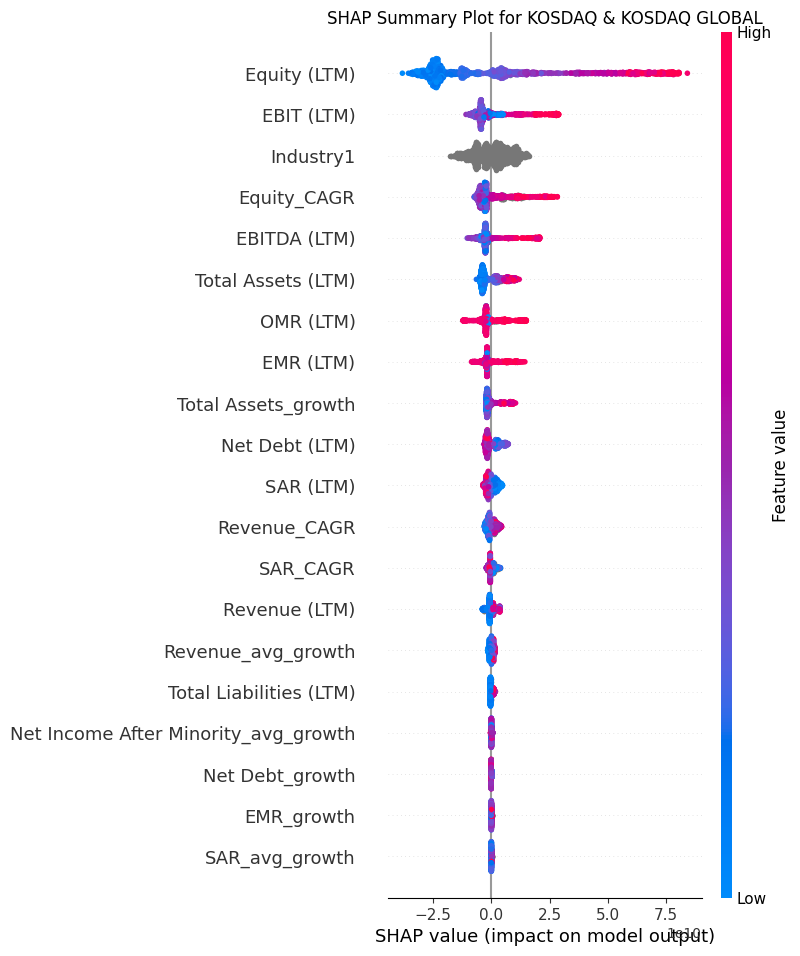


사용 가능한 변수 리스트 (79개):
  Industry1
  Industry2
  Industry3
  Industry4
  Industry5
  Net Debt (LTM)
  Total Liabilities (LTM)
  Total Assets (LTM)
  Equity (LTM)
  Revenue (LTM)
  Net Income (LTM)
  Net Income After Minority (LTM)
  EBIT (LTM)
  Dividends (LTM)
  EBITDA (LTM)
  Listing_Age_Days
  industry_PER_feature
  industry_EV_EBITDA_feature
  Total Assets_growth
  Total Assets_avg_growth
  Total Assets_CAGR
  Total Liabilities_growth
  Total Liabilities_avg_growth
  Total Liabilities_CAGR
  Equity_growth
  Equity_avg_growth
  Equity_CAGR
  Net Debt_growth
  Net Debt_avg_growth
  Net Debt_CAGR
  Revenue_growth
  Revenue_avg_growth
  Revenue_CAGR
  EBIT_growth
  EBIT_avg_growth
  EBIT_CAGR
  EBITDA_growth
  EBITDA_avg_growth
  EBITDA_CAGR
  Net Income_growth
  Net Income_avg_growth
  Net Income_CAGR
  Net Income After Minority_growth
  Net Income After Minority_avg_growth
  Net Income After Minority_CAGR
  Dividends_growth
  Dividends_avg_growth
  Dividends_CAGR
  BAR (LTM)
  DBR (LT

[I 2025-05-25 04:01:56,207] A new study created in memory with name: no-name-162126ce-7045-4a76-9656-16766f779994



[KOSPI] 선택된 피처 (22개):
  Equity (LTM): 266.00
  Listing_Age_Days: 221.00
  Net Income After Minority (LTM): 191.00
  Dividends_growth: 191.00
  Revenue (LTM): 178.00
  Total Assets (LTM): 147.00
  Dividends (LTM): 144.00
  EBIT (LTM): 143.00
  Revenue_CAGR: 136.00
  Total Liabilities_CAGR: 126.00
  industry_PER_feature: 124.00
  industry_EV_EBITDA_feature: 120.00
  Revenue_growth: 119.00
  Dividends_avg_growth: 117.00
  SAR_CAGR: 105.00
  Equity_growth: 104.00
  Net Debt (LTM): 99.00
  DBR_growth: 99.00
  SAR_growth: 99.00
  Net Income After Minority_avg_growth: 99.00
  EBR_CAGR: 95.00
  Net Debt_growth: 92.00
  Revenue_avg_growth: 88.00
  Net Debt_avg_growth: 86.00
  EAR_CAGR: 86.00
  Net Income (LTM): 85.00
  Total Liabilities (LTM): 85.00
  Dividends_CAGR: 85.00
  EMR_avg_growth: 76.00


[I 2025-05-25 04:01:56,551] Trial 0 finished with value: 0.7335710948763794 and parameters: {'learning_rate': 0.27799064000029283, 'num_leaves': 94, 'max_depth': 12, 'min_child_samples': 60, 'subsample': 0.7359117992480974, 'colsample_bytree': 0.8471788056312761, 'reg_alpha': 3.6128515689332437, 'reg_lambda': 6.2912294369338975}. Best is trial 0 with value: 0.7335710948763794.
[I 2025-05-25 04:01:56,644] Trial 1 finished with value: 0.7283408930749066 and parameters: {'learning_rate': 0.15273686737921022, 'num_leaves': 83, 'max_depth': 5, 'min_child_samples': 51, 'subsample': 0.8302607433066006, 'colsample_bytree': 0.6152052436911204, 'reg_alpha': 8.984017644350617, 'reg_lambda': 4.459949150597958}. Best is trial 1 with value: 0.7283408930749066.
[I 2025-05-25 04:01:56,985] Trial 3 finished with value: 0.7750858986388243 and parameters: {'learning_rate': 0.2365008012241264, 'num_leaves': 35, 'max_depth': 4, 'min_child_samples': 76, 'subsample': 0.6663645700369202, 'colsample_bytree': 0


[KOSPI] SHAP Feature Importances (Top 20):


,feature,importance
0,Equity (LTM),1.656293e+11
7,EBIT (LTM),1.263553e+11
6,Dividends (LTM),1.008828e+11
3,Net Income After Minority (LTM),7.634361e+10
5,Total Assets (LTM),6.239363e+10
10,industry_PER_feature,5.032985e+10
1,Listing_Age_Days,2.550118e+10
16,Net Debt (LTM),1.878836e+10
4,Revenue (LTM),1.469394e+10
8,Revenue_CAGR,1.456035e+10



[KOSPI] SHAP Summary Plot (Top 20 Features):


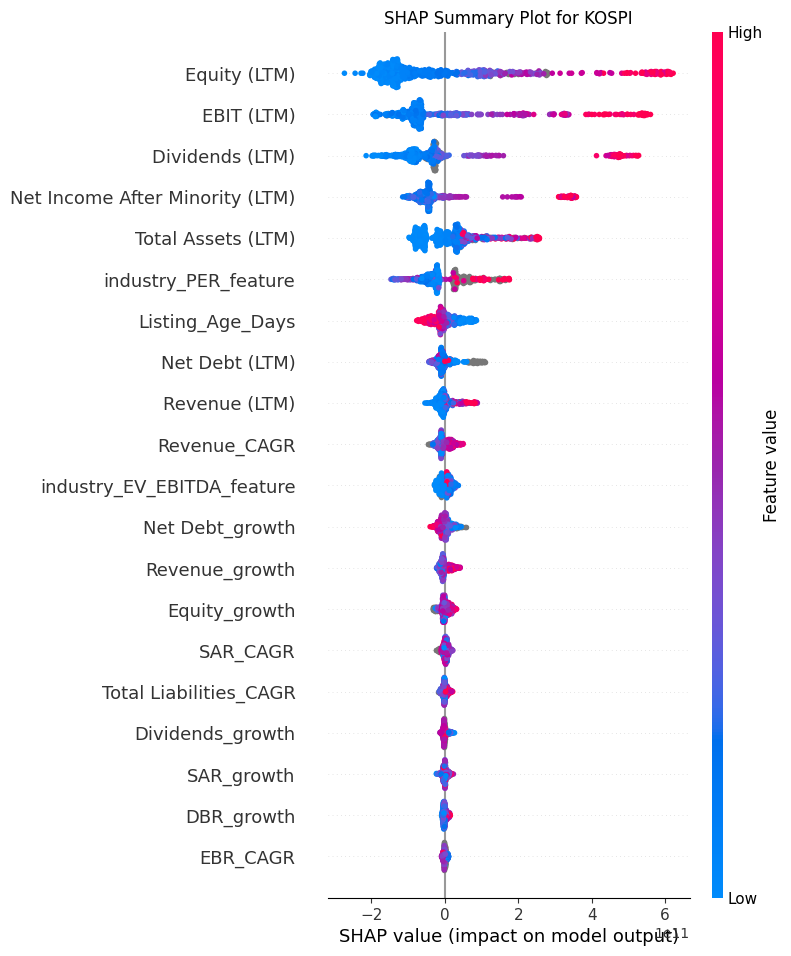

In [ ]:
!pip install optuna

import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
import optuna
import shap
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
import re
warnings.filterwarnings("ignore")

# 산업 PER 기반 피처 계산 (IQR 이상치 제거 후 조화평균)
def calculate_industry_per_feature(df):
    """산업별 PER을 계산하며, IQR로 이상치를 제거한 후 조화평균을 적용"""
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    industries = df[industry_cols].stack().dropna().unique()

    harm_means = {}
    for ind in industries:
        mask = df[industry_cols].apply(lambda r: ind in r.values, axis=1)
        sub = df.loc[mask & df['Net Income (LTM)'].gt(0) & df['Net Income (LTM)'].notna()]
        per_vals = sub['market_cap'] / sub['Net Income (LTM)']

        if len(per_vals) > 0:
            q1 = per_vals.quantile(0.25)
            q3 = per_vals.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 2 * iqr
            upper_bound = q3 + 2 * iqr
            per_vals_filtered = per_vals[(per_vals >= lower_bound) & (per_vals <= upper_bound)]
            harm_means[ind] = len(per_vals_filtered) / (1.0 / per_vals_filtered).sum() if len(per_vals_filtered) > 0 else np.nan
        else:
            harm_means[ind] = np.nan

    def feature(row):
        nets = row['Net Income (LTM)']
        if nets <= 0 or pd.isna(nets):
            return np.nan
        inds = [row[c] for c in industry_cols if pd.notna(row[c])]
        hms = [harm_means[i] for i in inds if not np.isnan(harm_means.get(i, np.nan))]
        return np.mean(hms) * nets if hms else np.nan

    return df.apply(feature, axis=1)

# 산업 EV/EBITDA 기반 피처 계산 (IQR 이상치 제거 후 조화평균)
def calculate_industry_EV_EBITDA_feature(df):
    """산업별 EV/EBITDA를 계산하며, IQR로 이상치를 제거한 후 조화평균을 적용"""
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    industries = df[industry_cols].stack().dropna().unique()

    harm_means_ev = {}
    for ind in industries:
        mask = df[industry_cols].apply(lambda r: ind in r.values, axis=1)
        sub = df.loc[mask & df['EBITDA (LTM)'].gt(0) & df['EBITDA (LTM)'].notna() & df['Enterprise Value (FQ0)'].notna()]
        ev_vals = sub['Enterprise Value (FQ0)'] / sub['EBITDA (LTM)']

        if len(ev_vals) > 0:
            q1 = ev_vals.quantile(0.25)
            q3 = ev_vals.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 2 * iqr
            upper_bound = q3 + 2 * iqr
            ev_vals_filtered = ev_vals[(ev_vals >= lower_bound) & (ev_vals <= upper_bound)]
            harm_means_ev[ind] = len(ev_vals_filtered) / (1.0 / ev_vals_filtered).sum() if len(ev_vals_filtered) > 0 else np.nan
        else:
            harm_means_ev[ind] = np.nan

    def feature_ev(row):
        ebitda = row['EBITDA (LTM)']
        if ebitda <= 0 or pd.isna(ebitda):
            return np.nan
        inds = [row[c] for c in industry_cols if pd.notna(row[c])]
        hms = [harm_means_ev[i] for i in inds if not np.isnan(harm_means_ev.get(i, np.nan))]
        return np.mean(hms) * ebitda if hms else np.nan

    return df.apply(feature_ev, axis=1)

# 도메인 및 시간 기반 피처 엔지니어링 클래스
class DomainFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        Xt = self._transform(X.copy())
        self.cols_ = Xt.columns.tolist()
        print(f"\n사용 가능한 변수 리스트 ({len(self.cols_)}개):")
        for col in self.cols_:
            print(f"  {col}")
        return self

    def transform(self, X):
        Xt = self._transform(X.copy())
        return Xt.reindex(columns=self.cols_, fill_value=0)

    def _transform(self, X):
        X = X.drop('market', axis=1, errors='ignore')
        tcols = [c for c in X.columns if '(' in c and 'LTM' in c]
        tf = {}
        for c in tcols:
            base, per = c.split(' (')
            tf.setdefault(base, {})[per.rstrip(')')] = c

        if 'EBIT' in tf and 'Depreciation' in tf:
            for p, e in tf['EBIT'].items():
                d = tf['Depreciation'].get(p)
                if d:
                    X[f'EBITDA ({p})'] = X[e] + X[d]
            tf['EBITDA'] = {p: f'EBITDA ({p})' for p in tf['EBIT']}

        bases = ['Total Assets', 'Total Liabilities', 'Equity', 'Net Debt',
                 'Revenue', 'EBIT', 'EBITDA', 'Net Income', 'Net Income After Minority', 'Dividends']

        def safe_div(a, b):
            return a.div(b.replace({0: np.nan}))

        for v in bases:
            periods = tf.get(v, {})
            seq = [p for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if p in periods]
            grs = []
            for i in range(1, len(seq)):
                prev, curr = seq[i-1], seq[i]
                r = safe_div(X[periods[curr]] - X[periods[prev]], X[periods[prev]])
                suffix = '-2' if (prev, curr) == ('LTM-3', 'LTM-2') else '-1' if (prev, curr) == ('LTM-2', 'LTM-1') else ''
                X[f'{v}_growth{suffix}'] = r
                grs.append(r)
            if grs:
                X[f'{v}_avg_growth'] = pd.concat(grs, axis=1).mean(axis=1)
            if 'LTM-3' in periods and 'LTM' in periods:
                X[f'{v}_CAGR'] = np.where(
                    X[periods['LTM-3']] > 0,
                    (X[periods['LTM']] / X[periods['LTM-3']])**(1/3) - 1,
                    np.nan
                )

        def calc(a, b, name, per):
            if per in tf.get(a, {}) and per in tf.get(b, {}):
                X[f'{name} ({per})'] = safe_div(X[tf[a][per]], X[tf[b][per]])

        ratios = [
            ('Equity', 'Total Assets', 'BAR'),
            ('Total Liabilities', 'Equity', 'DBR'),
            ('Revenue', 'Total Assets', 'SAR'),
            ('EBIT', 'Revenue', 'OMR'),
            ('EBITDA', 'Revenue', 'EMR'),
            ('Net Income', 'Total Assets', 'EAR'),
            ('Net Income', 'Equity', 'EBR')
        ]
        for p in ['LTM', 'LTM-1', 'LTM-2', 'LTM-3']:
            for a, b, n in ratios:
                calc(a, b, n, p)
            if p in ['LTM-2', 'LTM-1', 'LTM']:
                ni = tf.get('Net Income After Minority', {}).get(p)
                eq = tf.get('Equity', {}).get(p)
                prev = {'LTM-2': 'LTM-3', 'LTM-1': 'LTM-2', 'LTM': 'LTM-1'}[p]
                ep = tf.get('Equity', {}).get(prev)
                if ni and eq and ep:
                    avg_eq = (X[eq] + X[ep]) / 2
                    X[f'ROE ({p})'] = safe_div(X[ni], avg_eq)

        ratio_bases = ['BAR', 'DBR', 'SAR', 'OMR', 'EMR', 'EAR', 'EBR', 'ROE']
        for v in ratio_bases:
            periods = {p: f'{v} ({p})' for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if f'{v} ({p})' in X.columns}
            seq = [p for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if p in periods]
            grs = []
            for i in range(1, len(seq)):
                prev, curr = seq[i-1], seq[i]
                r = safe_div(X[periods[curr]] - X[periods[prev]], X[periods[prev]])
                suffix = '-2' if (prev, curr) == ('LTM-3', 'LTM-2') else '-1' if (prev, curr) == ('LTM-2', 'LTM-1') else ''
                X[f'{v}_growth{suffix}'] = r
                grs.append(r)
            if grs:
                X[f'{v}_avg_growth'] = pd.concat(grs, axis=1).mean(axis=1)
            if 'LTM-3' in periods and 'LTM' in periods:
                X[f'{v}_CAGR'] = np.where(
                    X[periods['LTM-3']] > 0,
                    (X[periods['LTM']] / X[periods['LTM-3']])**(1/3) - 1,
                    np.nan
                )

        dep_cols = [c for c in X.columns if c.startswith('Depreciation')]
        if dep_cols:
            X.drop(columns=dep_cols, inplace=True)

        industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
        for col in industry_cols:
            if col in X.columns:
                X[col] = X[col].astype('category')

        exclude_cols = [col for col in X.columns if re.search(r'\(LTM-\d+\)$|_growth-\d+$', col)]
        X = X.drop(columns=exclude_cols)

        return X

# LightGBM 하이퍼파라미터 최적화 (MAPE)
def optimize_lightgbm(X, y, n_trials=50):
    """LightGBM 모델의 하이퍼파라미터를 최적화하며 MAPE를 최소화"""
    def objective(trial):
        param = {
            'objective': 'quantile',
            'alpha': 0.5,
            'n_estimators': 1000,  # Large number, early stopping will adjust
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        val_mapes = []
        cat_cols = [col for col in ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5'] if col in X.columns]

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = LGBMRegressor(**param)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='quantile',
                callbacks=[early_stopping(stopping_rounds=10, verbose=False)],
                categorical_feature=cat_cols
            )
            y_pred = model.predict(X_val)
            # MAPE 계산: |actual - predicted| / |actual| for non-zero actual values
            mask = y_val != 0
            mape = np.mean(np.abs((y_val[mask] - y_pred[mask]) / y_val[mask])) if mask.sum() > 0 else np.inf
            val_mapes.append(mape)

        return np.mean(val_mapes)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)
    best_params = study.best_params
    best_params.update({
        'objective': 'quantile',
        'alpha': 0.5,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    })
    return best_params

# LightGBM 0.5 quantile 모델 실행 및 SHAP 분석
def quick_lightgbm_quantile(df, name):
    """LightGBM 0.5 quantile 모델을 실행하고 SHAP 피처 중요도를 계산 및 시각화"""
    df = df.copy()

    # EBITDA 생성
    if 'EBITDA (LTM)' not in df and 'EBIT (LTM)' in df and 'Depreciation (LTM)' in df:
        df['EBITDA (LTM)'] = df['EBIT (LTM)'] + df['Depreciation (LTM)']

    # 상장일 변환
    df['Listing_Age_Days'] = (pd.to_datetime('2024-12-31') - pd.to_datetime(df['Listing Date'])).dt.days
    df.drop(columns=['Listing Date'], inplace=True)

    # 산업 피처 계산
    df['industry_PER_feature'] = calculate_industry_per_feature(df)
    df['industry_EV_EBITDA_feature'] = calculate_industry_EV_EBITDA_feature(df)

    # 카테고리 변수 설정
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    for col in industry_cols:
        if col in df:
            df[col] = df[col].astype('category')

    # 설명 변수 선택
    X = df.select_dtypes(include=[np.number, 'category']).drop(
        columns=['Market Cap (2024-12-31)', 'market_cap', 'Enterprise Value (FQ0)'], errors='ignore')
    y = df['market_cap']

    # 피처 엔지니어링
    fe = DomainFeatureEngineer().fit(X, y)
    X_fe = fe.transform(X)

    # 피처 선택
    selector = LGBMRegressor(n_estimators=200, random_state=42)
    selector.fit(X_fe, y)
    imp = pd.Series(selector.feature_importances_, index=X_fe.columns)
    selected = imp[imp > imp.mean() * 1.2].sort_values(ascending=False).index.tolist()

    print(f"\n[{name}] 선택된 피처 ({len(selected)}개):")
    for feat, score in imp[imp > imp.mean()].sort_values(ascending=False).items():
        print(f"  {feat}: {score:.2f}")

    # 모델 최적화 및 학습
    X_sel = X_fe[selected]
    best_params = optimize_lightgbm(X_sel, y)
    cat_cols = [col for col in industry_cols if col in X_sel.columns]

    model = LGBMRegressor(**best_params)
    model.fit(X_sel, y, categorical_feature=cat_cols)

    # SHAP 값 계산
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sel)

    # 피처 중요도 계산 및 표 출력
    shap_importances = np.abs(shap_values).mean(axis=0)
    feature_importance_df = pd.DataFrame({
        'feature': X_sel.columns,
        'importance': shap_importances
    }).sort_values(by='importance', ascending=False)

    print(f"\n[{name}] SHAP Feature Importances (Top 20):")
    display(feature_importance_df.head(20))

    # SHAP Summary Plot (Beeswarm)
    print(f"\n[{name}] SHAP Summary Plot (Top 20 Features):")
    shap.summary_plot(shap_values, X_sel, max_display=20, show=False)
    plt.title(f"SHAP Summary Plot for {name}")
    display(plt.gcf())
    plt.close()

    return feature_importance_df

# 메인 실행
if __name__ == "__main__":
    PATH = "/content/5_7_데이터.xlsx"
    df = pd.read_excel(PATH, sheet_name="Sheet1")

    # 데이터 전처리
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    for col in industry_cols:
        if col in df:
            df[col] = df[col].astype('category')

    df = df[df["market"].isin(["KOSDAQ", "KOSDAQ GLOBAL", "KOSPI"]) & (df["Market Cap (2024-12-31)"] > 0)]
    df["market_cap"] = df["Market Cap (2024-12-31)"]

    exclude_tickers = set(['003380', '005290', '005990', '006730', '007330', '012700', '013120', '013310', '015750', '016250',
                           '018310', '019210', '021320', '023410', '023760', '025900', '025980', '027710', '028300', '030530',
                           '031330', '032190', '033160', '033290', '033640', '034810', '035080', '035600', '035760', '035810',
                           '035890', '035900', '036710', '036800', '036830', '036930', '037460', '038110', '038390', '038500',
                           '038540', '041190', '041510', '043370', '046890', '049070', '051500', '053700', '056190', '058470',
                           '061970', '064760', '064820', '067160', '067170', '067310', '067570', '067990', '069080', '071460',
                           '074600', '078020', '078340', '080420', '084110', '084850', '085660', '086520', '091700', '092190',
                           '096530', '100790', '101330', '104480', '112040', '115160', '121440', '122450', '122690', '123040',
                           '124500', '131970', '136480', '137400', '141080', '145020', '151860', '178320', '195940', '205470',
                           '214450', '215000', '215200', '222800', '240810', '247540', '253450', '263750', '267980', '293490',
                           '348370', '357780', '393890', '403870', '900290', '950130', '000270', '000660', '000810', '000880',
                           '001040', '003490', '003550', '004020', '005380', '005490', '005830', '005930', '005940', '006400',
                           '006800', '009540', '010950', '011170', '011200', '012330', '015760', '016360', '017670', '023530',
                           '023590', '024110', '028260', '030200', '032830', '034220', '034730', '035420', '035720', '036460',
                           '042660', '051910', '055550', '066570', '071050', '078930', '086790', '088350', '096770', '097950',
                           '105560', '138040', '138930', '139130', '139480', '207940', '267250', '316140', '373220', '402340',
                           '415640'])
    df = df[~df['ticker'].isin(exclude_tickers)].reset_index(drop=True)

    num_cols = df.select_dtypes(include=[np.number]).columns
    df = df[df[num_cols].isnull().mean(axis=1) <= 0.5].reset_index(drop=True)

    # 시장별 데이터 분리 및 모델 실행
    kosdaq = df[df["market"].isin(["KOSDAQ", "KOSDAQ GLOBAL"])]
    kospi = df[df["market"] == "KOSPI"]

    res1 = quick_lightgbm_quantile(kosdaq, "KOSDAQ & KOSDAQ GLOBAL")
    res2 = quick_lightgbm_quantile(kospi, "KOSPI")


사용 가능한 변수 리스트 (79개):
  Industry1
  Industry2
  Industry3
  Industry4
  Industry5
  Net Debt (LTM)
  Total Liabilities (LTM)
  Total Assets (LTM)
  Equity (LTM)
  Revenue (LTM)
  Net Income (LTM)
  Net Income After Minority (LTM)
  EBIT (LTM)
  Dividends (LTM)
  EBITDA (LTM)
  Listing_Age_Days
  industry_PER_feature
  industry_EV_EBITDA_feature
  Total Assets_growth
  Total Assets_avg_growth
  Total Assets_CAGR
  Total Liabilities_growth
  Total Liabilities_avg_growth
  Total Liabilities_CAGR
  Equity_growth
  Equity_avg_growth
  Equity_CAGR
  Net Debt_growth
  Net Debt_avg_growth
  Net Debt_CAGR
  Revenue_growth
  Revenue_avg_growth
  Revenue_CAGR
  EBIT_growth
  EBIT_avg_growth
  EBIT_CAGR
  EBITDA_growth
  EBITDA_avg_growth
  EBITDA_CAGR
  Net Income_growth
  Net Income_avg_growth
  Net Income_CAGR
  Net Income After Minority_growth
  Net Income After Minority_avg_growth
  Net Income After Minority_CAGR
  Dividends_growth
  Dividends_avg_growth
  Dividends_CAGR
  BAR (LTM)
  DBR (LT

[I 2025-05-25 05:26:16,729] A new study created in memory with name: no-name-3412f975-0c21-4d8c-95ab-22d86c4c223e



[KOSDAQ & KOSDAQ GLOBAL] 선택된 피처 (29개):
  SAR_CAGR: 261.00
  Equity (LTM): 244.00
  Revenue_CAGR: 231.00
  EMR_growth: 227.00
  Total Assets (LTM): 215.00
  EBITDA (LTM): 163.00
  SAR (LTM): 156.00
  Total Liabilities (LTM): 153.00
  Revenue (LTM): 149.00
  Net Debt_growth: 142.00
  Net Debt (LTM): 140.00
  Revenue_avg_growth: 125.00
  Industry1: 123.00
  Equity_CAGR: 114.00
  EBIT (LTM): 110.00
  Total Assets_growth: 109.00
  OMR (LTM): 109.00
  SAR_growth: 105.00
  EBR_growth: 97.00
  EMR (LTM): 95.00
  SAR_avg_growth: 93.00
  Net Income After Minority_avg_growth: 92.00
  EBITDA_growth: 91.00
  Revenue_growth: 90.00
  Dividends (LTM): 90.00
  ROE_avg_growth: 90.00
  Dividends_growth: 88.00
  industry_EV_EBITDA_feature: 87.00
  Net Income_growth: 77.00


[I 2025-05-25 05:26:17,772] Trial 1 finished with value: 0.600584697517176 and parameters: {'learning_rate': 0.23048708080031, 'num_leaves': 28, 'max_depth': 6, 'min_child_samples': 82, 'subsample': 0.6723683906776461, 'colsample_bytree': 0.7859997215965151, 'reg_alpha': 7.446918778187634, 'reg_lambda': 2.5428776721914095}. Best is trial 1 with value: 0.600584697517176.
[I 2025-05-25 05:26:17,978] Trial 0 finished with value: 0.5919380206362791 and parameters: {'learning_rate': 0.15718762870945702, 'num_leaves': 140, 'max_depth': 5, 'min_child_samples': 90, 'subsample': 0.9775814425646208, 'colsample_bytree': 0.6361568735919462, 'reg_alpha': 7.506590154494286, 'reg_lambda': 6.086358591477185}. Best is trial 0 with value: 0.5919380206362791.
[I 2025-05-25 05:26:19,907] Trial 2 finished with value: 0.6035881837437918 and parameters: {'learning_rate': 0.1114246521672636, 'num_leaves': 112, 'max_depth': 6, 'min_child_samples': 85, 'subsample': 0.6841958002525947, 'colsample_bytree': 0.9793


[KOSDAQ & KOSDAQ GLOBAL] SHAP Feature Importances and Direction (Top 20):
양수 mean_shap_value: 시가총액 증가에 기여
음수 mean_shap_value: 시가총액 감소에 기여


,feature,shap_importance,mean_shap_value
1,Equity (LTM),2.489876e+10,9.173361e+08
14,EBIT (LTM),1.129028e+10,-3.811925e+08
12,Industry1,9.097716e+09,3.115206e+08
13,Equity_CAGR,6.996545e+09,1.419509e+08
10,Net Debt (LTM),5.679590e+09,9.295034e+07
4,Total Assets (LTM),5.524034e+09,3.507275e+08
16,OMR (LTM),5.319589e+09,-9.024561e+08
24,Dividends (LTM),5.130241e+09,-4.018824e+08
27,industry_EV_EBITDA_feature,4.906488e+09,-1.130649e+08
5,EBITDA (LTM),4.206332e+09,1.413482e+08



[KOSDAQ & KOSDAQ GLOBAL] SHAP Summary Plot (Top 20 Features):


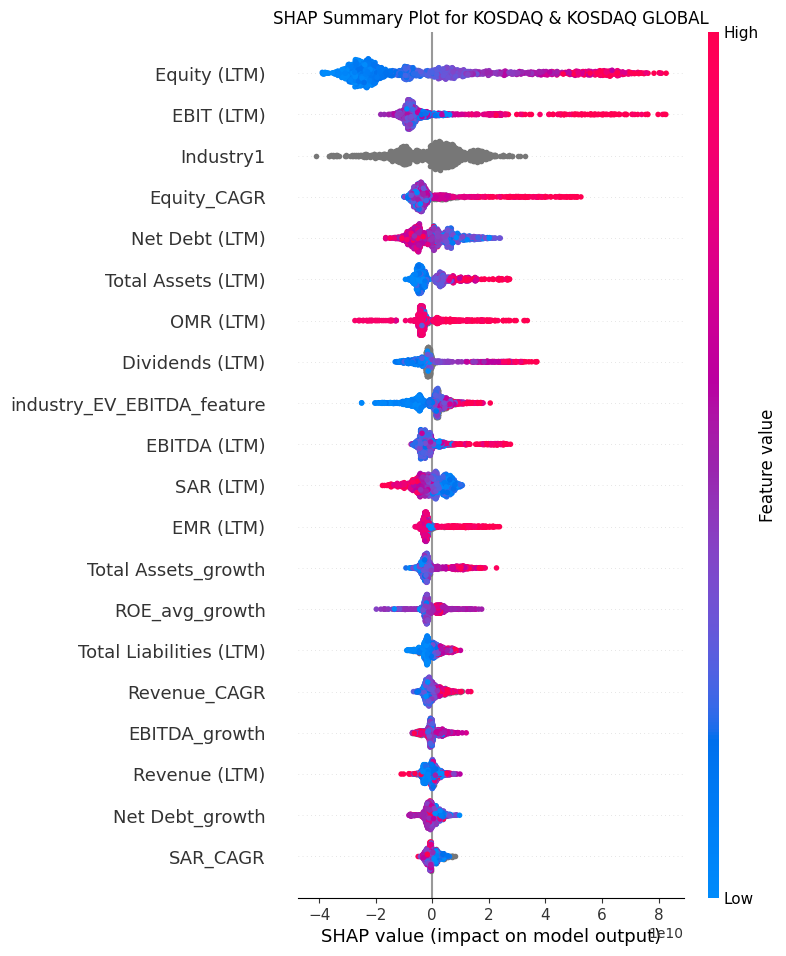


사용 가능한 변수 리스트 (79개):
  Industry1
  Industry2
  Industry3
  Industry4
  Industry5
  Net Debt (LTM)
  Total Liabilities (LTM)
  Total Assets (LTM)
  Equity (LTM)
  Revenue (LTM)
  Net Income (LTM)
  Net Income After Minority (LTM)
  EBIT (LTM)
  Dividends (LTM)
  EBITDA (LTM)
  Listing_Age_Days
  industry_PER_feature
  industry_EV_EBITDA_feature
  Total Assets_growth
  Total Assets_avg_growth
  Total Assets_CAGR
  Total Liabilities_growth
  Total Liabilities_avg_growth
  Total Liabilities_CAGR
  Equity_growth
  Equity_avg_growth
  Equity_CAGR
  Net Debt_growth
  Net Debt_avg_growth
  Net Debt_CAGR
  Revenue_growth
  Revenue_avg_growth
  Revenue_CAGR
  EBIT_growth
  EBIT_avg_growth
  EBIT_CAGR
  EBITDA_growth
  EBITDA_avg_growth
  EBITDA_CAGR
  Net Income_growth
  Net Income_avg_growth
  Net Income_CAGR
  Net Income After Minority_growth
  Net Income After Minority_avg_growth
  Net Income After Minority_CAGR
  Dividends_growth
  Dividends_avg_growth
  Dividends_CAGR
  BAR (LTM)
  DBR (LT

[I 2025-05-25 05:27:02,565] A new study created in memory with name: no-name-5e556574-4297-43ed-a89a-736f364d5ed9



[KOSPI] 선택된 피처 (29개):
  Equity (LTM): 266.00
  Listing_Age_Days: 221.00
  Net Income After Minority (LTM): 191.00
  Dividends_growth: 191.00
  Revenue (LTM): 178.00
  Total Assets (LTM): 147.00
  Dividends (LTM): 144.00
  EBIT (LTM): 143.00
  Revenue_CAGR: 136.00
  Total Liabilities_CAGR: 126.00
  industry_PER_feature: 124.00
  industry_EV_EBITDA_feature: 120.00
  Revenue_growth: 119.00
  Dividends_avg_growth: 117.00
  SAR_CAGR: 105.00
  Equity_growth: 104.00
  Net Debt (LTM): 99.00
  DBR_growth: 99.00
  SAR_growth: 99.00
  Net Income After Minority_avg_growth: 99.00
  EBR_CAGR: 95.00
  Net Debt_growth: 92.00
  Revenue_avg_growth: 88.00
  Net Debt_avg_growth: 86.00
  EAR_CAGR: 86.00
  Net Income (LTM): 85.00
  Total Liabilities (LTM): 85.00
  Dividends_CAGR: 85.00
  EMR_avg_growth: 76.00


[I 2025-05-25 05:27:04,096] Trial 1 finished with value: 0.7104792751921247 and parameters: {'learning_rate': 0.08981622751638337, 'num_leaves': 115, 'max_depth': 11, 'min_child_samples': 67, 'subsample': 0.6083843082403643, 'colsample_bytree': 0.893382227767247, 'reg_alpha': 3.959107381693806, 'reg_lambda': 7.831731843589845}. Best is trial 1 with value: 0.7104792751921247.
[I 2025-05-25 05:27:04,120] Trial 0 finished with value: 0.723909952907777 and parameters: {'learning_rate': 0.10663812311180562, 'num_leaves': 50, 'max_depth': 14, 'min_child_samples': 91, 'subsample': 0.6492803927440836, 'colsample_bytree': 0.7771602995030151, 'reg_alpha': 0.6501859429838286, 'reg_lambda': 8.063787760033449}. Best is trial 1 with value: 0.7104792751921247.
[I 2025-05-25 05:27:04,764] Trial 3 finished with value: 0.7334293723500503 and parameters: {'learning_rate': 0.1440432705093314, 'num_leaves': 52, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.6560378387402873, 'colsample_bytree': 0


[KOSPI] SHAP Feature Importances and Direction (Top 20):
양수 mean_shap_value: 시가총액 증가에 기여
음수 mean_shap_value: 시가총액 감소에 기여


,feature,shap_importance,mean_shap_value
0,Equity (LTM),1.734839e+11,1.071145e+10
6,Dividends (LTM),1.488566e+11,1.086842e+10
7,EBIT (LTM),1.266120e+11,-9.663635e+09
2,Net Income After Minority (LTM),1.183580e+11,4.071703e+09
10,industry_PER_feature,8.408104e+10,-5.809750e+09
1,Listing_Age_Days,3.753444e+10,-4.342919e+08
21,Net Debt_growth,3.432704e+10,-5.393634e+09
4,Revenue (LTM),3.158723e+10,-1.239996e+09
11,industry_EV_EBITDA_feature,2.959072e+10,-5.802878e+09
16,Net Debt (LTM),1.764576e+10,2.874002e+08



[KOSPI] SHAP Summary Plot (Top 20 Features):


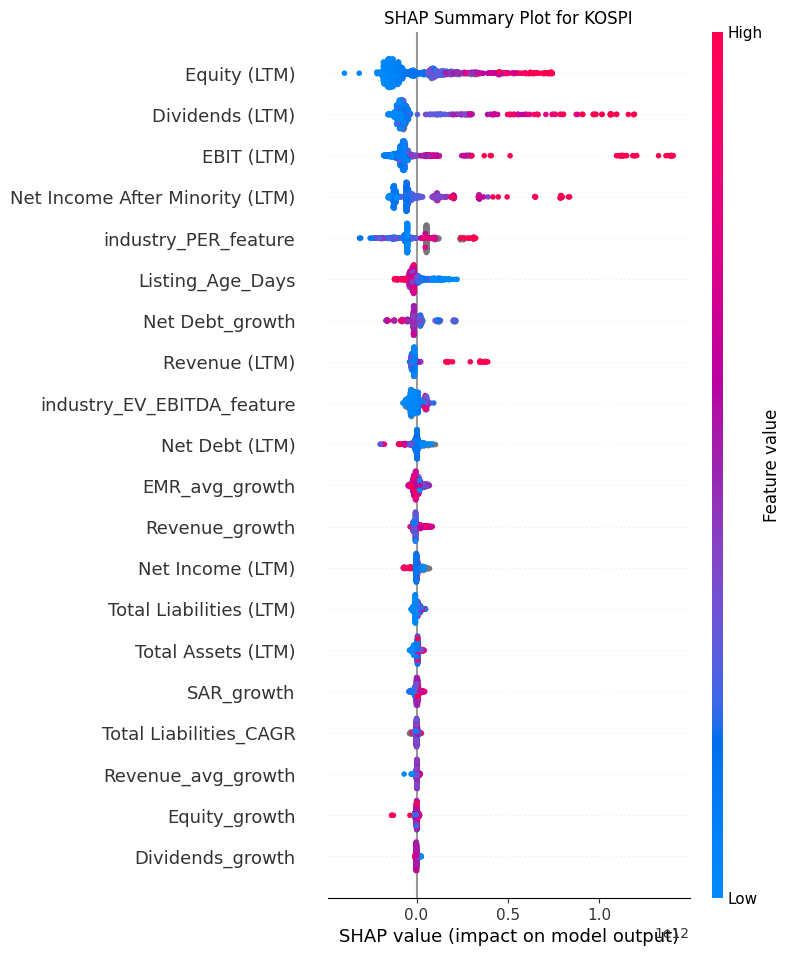

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
import optuna
import shap
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
import re
warnings.filterwarnings("ignore")

# 산업 PER 기반 피처 계산 (IQR 이상치 제거 후 조화평균)
def calculate_industry_per_feature(df):
    """산업별 PER을 계산하며, IQR로 이상치를 제거한 후 조화평균을 적용"""
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    industries = df[industry_cols].stack().dropna().unique()

    harm_means = {}
    for ind in industries:
        mask = df[industry_cols].apply(lambda r: ind in r.values, axis=1)
        sub = df.loc[mask & df['Net Income (LTM)'].gt(0) & df['Net Income (LTM)'].notna()]
        per_vals = sub['market_cap'] / sub['Net Income (LTM)']

        if len(per_vals) > 0:
            q1 = per_vals.quantile(0.25)
            q3 = per_vals.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 2 * iqr
            upper_bound = q3 + 2 * iqr
            per_vals_filtered = per_vals[(per_vals >= lower_bound) & (per_vals <= upper_bound)]
            harm_means[ind] = len(per_vals_filtered) / (1.0 / per_vals_filtered).sum() if len(per_vals_filtered) > 0 else np.nan
        else:
            harm_means[ind] = np.nan

    def feature(row):
        nets = row['Net Income (LTM)']
        if nets <= 0 or pd.isna(nets):
            return np.nan
        inds = [row[c] for c in industry_cols if pd.notna(row[c])]
        hms = [harm_means[i] for i in inds if not np.isnan(harm_means.get(i, np.nan))]
        return np.mean(hms) * nets if hms else np.nan

    return df.apply(feature, axis=1)

# 산업 EV/EBITDA 기반 피처 계산 (IQR 이상치 제거 후 조화평균)
def calculate_industry_EV_EBITDA_feature(df):
    """산업별 EV/EBITDA를 계산하며, IQR로 이상치를 제거한 후 조화평균을 적용"""
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    industries = df[industry_cols].stack().dropna().unique()

    harm_means_ev = {}
    for ind in industries:
        mask = df[industry_cols].apply(lambda r: ind in r.values, axis=1)
        sub = df.loc[mask & df['EBITDA (LTM)'].gt(0) & df['EBITDA (LTM)'].notna() & df['Enterprise Value (FQ0)'].notna()]
        ev_vals = sub['Enterprise Value (FQ0)'] / sub['EBITDA (LTM)']

        if len(ev_vals) > 0:
            q1 = ev_vals.quantile(0.25)
            q3 = ev_vals.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 2 * iqr
            upper_bound = q3 + 2 * iqr
            ev_vals_filtered = ev_vals[(ev_vals >= lower_bound) & (ev_vals <= upper_bound)]
            harm_means_ev[ind] = len(ev_vals_filtered) / (1.0 / ev_vals_filtered).sum() if len(ev_vals_filtered) > 0 else np.nan
        else:
            harm_means_ev[ind] = np.nan

    def feature_ev(row):
        ebitda = row['EBITDA (LTM)']
        if ebitda <= 0 or pd.isna(ebitda):
            return np.nan
        inds = [row[c] for c in industry_cols if pd.notna(row[c])]
        hms = [harm_means_ev[i] for i in inds if not np.isnan(harm_means_ev.get(i, np.nan))]
        return np.mean(hms) * ebitda if hms else np.nan

    return df.apply(feature_ev, axis=1)

# 도메인 및 시간 기반 피처 엔지니어링 클래스
class DomainFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        Xt = self._transform(X.copy())
        self.cols_ = Xt.columns.tolist()
        print(f"\n사용 가능한 변수 리스트 ({len(self.cols_)}개):")
        for col in self.cols_:
            print(f"  {col}")
        return self

    def transform(self, X):
        Xt = self._transform(X.copy())
        return Xt.reindex(columns=self.cols_, fill_value=0)

    def _transform(self, X):
        X = X.drop('market', axis=1, errors='ignore')
        tcols = [c for c in X.columns if '(' in c and 'LTM' in c]
        tf = {}
        for c in tcols:
            base, per = c.split(' (')
            tf.setdefault(base, {})[per.rstrip(')')] = c

        if 'EBIT' in tf and 'Depreciation' in tf:
            for p, e in tf['EBIT'].items():
                d = tf['Depreciation'].get(p)
                if d:
                    X[f'EBITDA ({p})'] = X[e] + X[d]
            tf['EBITDA'] = {p: f'EBITDA ({p})' for p in tf['EBIT']}

        bases = ['Total Assets', 'Total Liabilities', 'Equity', 'Net Debt',
                 'Revenue', 'EBIT', 'EBITDA', 'Net Income', 'Net Income After Minority', 'Dividends']

        def safe_div(a, b):
            return a.div(b.replace({0: np.nan}))

        for v in bases:
            periods = tf.get(v, {})
            seq = [p for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if p in periods]
            grs = []
            for i in range(1, len(seq)):
                prev, curr = seq[i-1], seq[i]
                r = safe_div(X[periods[curr]] - X[periods[prev]], X[periods[prev]])
                suffix = '-2' if (prev, curr) == ('LTM-3', 'LTM-2') else '-1' if (prev, curr) == ('LTM-2', 'LTM-1') else ''
                X[f'{v}_growth{suffix}'] = r
                grs.append(r)
            if grs:
                X[f'{v}_avg_growth'] = pd.concat(grs, axis=1).mean(axis=1)
            if 'LTM-3' in periods and 'LTM' in periods:
                X[f'{v}_CAGR'] = np.where(
                    X[periods['LTM-3']] > 0,
                    (X[periods['LTM']] / X[periods['LTM-3']])**(1/3) - 1,
                    np.nan
                )

        def calc(a, b, name, per):
            if per in tf.get(a, {}) and per in tf.get(b, {}):
                X[f'{name} ({per})'] = safe_div(X[tf[a][per]], X[tf[b][per]])

        ratios = [
            ('Equity', 'Total Assets', 'BAR'),
            ('Total Liabilities', 'Equity', 'DBR'),
            ('Revenue', 'Total Assets', 'SAR'),
            ('EBIT', 'Revenue', 'OMR'),
            ('EBITDA', 'Revenue', 'EMR'),
            ('Net Income', 'Total Assets', 'EAR'),
            ('Net Income', 'Equity', 'EBR')
        ]
        for p in ['LTM', 'LTM-1', 'LTM-2', 'LTM-3']:
            for a, b, n in ratios:
                calc(a, b, n, p)
            if p in ['LTM-2', 'LTM-1', 'LTM']:
                ni = tf.get('Net Income After Minority', {}).get(p)
                eq = tf.get('Equity', {}).get(p)
                prev = {'LTM-2': 'LTM-3', 'LTM-1': 'LTM-2', 'LTM': 'LTM-1'}[p]
                ep = tf.get('Equity', {}).get(prev)
                if ni and eq and ep:
                    avg_eq = (X[eq] + X[ep]) / 2
                    X[f'ROE ({p})'] = safe_div(X[ni], avg_eq)

        ratio_bases = ['BAR', 'DBR', 'SAR', 'OMR', 'EMR', 'EAR', 'EBR', 'ROE']
        for v in ratio_bases:
            periods = {p: f'{v} ({p})' for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if f'{v} ({p})' in X.columns}
            seq = [p for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if p in periods]
            grs = []
            for i in range(1, len(seq)):
                prev, curr = seq[i-1], seq[i]
                r = safe_div(X[periods[curr]] - X[periods[prev]], X[periods[prev]])
                suffix = '-2' if (prev, curr) == ('LTM-3', 'LTM-2') else '-1' if (prev, curr) == ('LTM-2', 'LTM-1') else ''
                X[f'{v}_growth{suffix}'] = r
                grs.append(r)
            if grs:
                X[f'{v}_avg_growth'] = pd.concat(grs, axis=1).mean(axis=1)
            if 'LTM-3' in periods and 'LTM' in periods:
                X[f'{v}_CAGR'] = np.where(
                    X[periods['LTM-3']] > 0,
                    (X[periods['LTM']] / X[periods['LTM-3']])**(1/3) - 1,
                    np.nan
                )

        dep_cols = [c for c in X.columns if c.startswith('Depreciation')]
        if dep_cols:
            X.drop(columns=dep_cols, inplace=True)

        industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
        for col in industry_cols:
            if col in X.columns:
                X[col] = X[col].astype('category')

        exclude_cols = [col for col in X.columns if re.search(r'\(LTM-\d+\)$|_growth-\d+$', col)]
        X = X.drop(columns=exclude_cols)

        return X

# LightGBM 하이퍼파라미터 최적화 (MAPE)
def optimize_lightgbm(X, y, n_trials=50):
    """LightGBM 모델의 하이퍼파라미터를 최적화하며 MAPE를 최소화"""
    def objective(trial):
        param = {
            'objective': 'quantile',
            'alpha': 0.5,
            'n_estimators': 1000,  # Large number, early stopping will adjust
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        val_mapes = []
        cat_cols = [col for col in ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5'] if col in X.columns]

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = LGBMRegressor(**param)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='quantile',
                callbacks=[early_stopping(stopping_rounds=10, verbose=False)],
                categorical_feature=cat_cols
            )
            y_pred = model.predict(X_val)
            # MAPE 계산: |actual - predicted| / |actual| for non-zero actual values
            mask = y_val != 0
            mape = np.mean(np.abs((y_val[mask] - y_pred[mask]) / y_val[mask])) if mask.sum() > 0 else np.inf
            val_mapes.append(mape)

        return np.mean(val_mapes)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)
    best_params = study.best_params
    best_params.update({
        'objective': 'quantile',
        'alpha': 0.5,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    })
    return best_params

# LightGBM 0.5 quantile 모델 실행 및 SHAP 분석
def quick_lightgbm_quantile(df, name):
    """LightGBM 0.5 quantile 모델을 실행하고 SHAP 피처 중요도 및 방향성을 계산 및 시각화"""
    df = df.copy()

    # EBITDA 생성
    if 'EBITDA (LTM)' not in df and 'EBIT (LTM)' in df and 'Depreciation (LTM)' in df:
        df['EBITDA (LTM)'] = df['EBIT (LTM)'] + df['Depreciation (LTM)']

    # 상장일 변환
    df['Listing_Age_Days'] = (pd.to_datetime('2024-12-31') - pd.to_datetime(df['Listing Date'])).dt.days
    df.drop(columns=['Listing Date'], inplace=True)

    # 산업 피처 계산
    df['industry_PER_feature'] = calculate_industry_per_feature(df)
    df['industry_EV_EBITDA_feature'] = calculate_industry_EV_EBITDA_feature(df)

    # 카테고리 변수 설정
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    for col in industry_cols:
        if col in df:
            df[col] = df[col].astype('category')

    # 설명 변수 선택
    X = df.select_dtypes(include=[np.number, 'category']).drop(
        columns=['Market Cap (2024-12-31)', 'market_cap', 'Enterprise Value (FQ0)'], errors='ignore')
    y = df['market_cap']

    # 피처 엔지니어링
    fe = DomainFeatureEngineer().fit(X, y)
    X_fe = fe.transform(X)

    # 피처 선택
    selector = LGBMRegressor(n_estimators=200, random_state=42)
    selector.fit(X_fe, y)
    imp = pd.Series(selector.feature_importances_, index=X_fe.columns)
    selected = imp[imp > imp.mean() * 1].sort_values(ascending=False).index.tolist()

    print(f"\n[{name}] 선택된 피처 ({len(selected)}개):")
    for feat, score in imp[imp > imp.mean()].sort_values(ascending=False).items():
        print(f"  {feat}: {score:.2f}")

    # 모델 최적화 및 학습
    X_sel = X_fe[selected]
    best_params = optimize_lightgbm(X_sel, y)
    cat_cols = [col for col in industry_cols if col in X_sel.columns]

    model = LGBMRegressor(**best_params)
    model.fit(X_sel, y, categorical_feature=cat_cols)

    # SHAP 값 계산
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sel)

    # 피처 중요도 및 방향성 계산
    shap_importances = np.abs(shap_values).mean(axis=0)
    shap_means = np.mean(shap_values, axis=0)  # 평균 SHAP 값 (방향성)
    feature_importance_df = pd.DataFrame({
        'feature': X_sel.columns,
        'shap_importance': shap_importances,
        'mean_shap_value': shap_means
    }).sort_values(by='shap_importance', ascending=False)

    # 상위 20개 피처의 중요도와 방향성 출력
    print(f"\n[{name}] SHAP Feature Importances and Direction (Top 20):")
    print("양수 mean_shap_value: 시가총액 증가에 기여")
    print("음수 mean_shap_value: 시가총액 감소에 기여")
    display(feature_importance_df.head(20))

    # SHAP Summary Plot (Beeswarm)
    print(f"\n[{name}] SHAP Summary Plot (Top 20 Features):")
    shap.summary_plot(shap_values, X_sel, max_display=20, show=False)
    plt.title(f"SHAP Summary Plot for {name}")
    display(plt.gcf())
    plt.close()

    return feature_importance_df

# 메인 실행
if __name__ == "__main__":
    PATH = "/content/5_7_데이터.xlsx"
    df = pd.read_excel(PATH, sheet_name="Sheet1")

    # 데이터 전처리
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    for col in industry_cols:
        if col in df:
            df[col] = df[col].astype('category')

    df = df[df["market"].isin(["KOSDAQ", "KOSDAQ GLOBAL", "KOSPI"]) & (df["Market Cap (2024-12-31)"] > 0)]
    df["market_cap"] = df["Market Cap (2024-12-31)"]

    exclude_tickers = set(['003380', '005290', '005990', '006730', '007330', '012700', '013120', '013310', '015750', '016250',
                           '018310', '019210', '021320', '023410', '023760', '025900', '025980', '027710', '028300', '030530',
                           '031330', '032190', '033160', '033290', '033640', '034810', '035080', '035600', '035760', '035810',
                           '035890', '035900', '036710', '036800', '036830', '036930', '037460', '038110', '038390', '038500',
                           '038540', '041190', '041510', '043370', '046890', '049070', '051500', '053700', '056190', '058470',
                           '061970', '064760', '064820', '067160', '067170', '067310', '067570', '067990', '069080', '071460',
                           '074600', '078020', '078340', '080420', '084110', '084850', '085660', '086520', '091700', '092190',
                           '096530', '100790', '101330', '104480', '112040', '115160', '121440', '122450', '122690', '123040',
                           '124500', '131970', '136480', '137400', '141080', '145020', '151860', '178320', '195940', '205470',
                           '214450', '215000', '215200', '222800', '240810', '247540', '253450', '263750', '267980', '293490',
                           '348370', '357780', '393890', '403870', '900290', '950130', '000270', '000660', '000810', '000880',
                           '001040', '003490', '003550', '004020', '005380', '005490', '005830', '005930', '005940', '006400',
                           '006800', '009540', '010950', '011170', '011200', '012330', '015760', '016360', '017670', '023530',
                           '023590', '024110', '028260', '030200', '032830', '034220', '034730', '035420', '035720', '036460',
                           '042660', '051910', '055550', '066570', '071050', '078930', '086790', '088350', '096770', '097950',
                           '105560', '138040', '138930', '139130', '139480', '207940', '267250', '316140', '373220', '402340',
                           '415640'])
    df = df[~df['ticker'].isin(exclude_tickers)].reset_index(drop=True)

    num_cols = df.select_dtypes(include=[np.number]).columns
    df = df[df[num_cols].isnull().mean(axis=1) <= 0.5].reset_index(drop=True)

    # 시장별 데이터 분리 및 모델 실행
    kosdaq = df[df["market"].isin(["KOSDAQ", "KOSDAQ GLOBAL"])]
    kospi = df[df["market"] == "KOSPI"]

    res1 = quick_lightgbm_quantile(kosdaq, "KOSDAQ & KOSDAQ GLOBAL")
    res2 = quick_lightgbm_quantile(kospi, "KOSPI")


사용 가능한 변수 리스트 (79개):
  Industry1
  Industry2
  Industry3
  Industry4
  Industry5
  Net Debt (LTM)
  Total Liabilities (LTM)
  Total Assets (LTM)
  Equity (LTM)
  Revenue (LTM)
  Net Income (LTM)
  Net Income After Minority (LTM)
  EBIT (LTM)
  Dividends (LTM)
  EBITDA (LTM)
  Listing_Age_Days
  industry_PER_feature
  industry_EV_EBITDA_feature
  Total Assets_growth
  Total Assets_avg_growth
  Total Assets_CAGR
  Total Liabilities_growth
  Total Liabilities_avg_growth
  Total Liabilities_CAGR
  Equity_growth
  Equity_avg_growth
  Equity_CAGR
  Net Debt_growth
  Net Debt_avg_growth
  Net Debt_CAGR
  Revenue_growth
  Revenue_avg_growth
  Revenue_CAGR
  EBIT_growth
  EBIT_avg_growth
  EBIT_CAGR
  EBITDA_growth
  EBITDA_avg_growth
  EBITDA_CAGR
  Net Income_growth
  Net Income_avg_growth
  Net Income_CAGR
  Net Income After Minority_growth
  Net Income After Minority_avg_growth
  Net Income After Minority_CAGR
  Dividends_growth
  Dividends_avg_growth
  Dividends_CAGR
  BAR (LTM)
  DBR (LT

[I 2025-05-25 06:31:23,085] A new study created in memory with name: no-name-e693499f-dde2-473a-8978-27bebbf1f5d1



[KOSDAQ & KOSDAQ GLOBAL] 선택된 피처 (31개):
  SAR_CAGR: 264.00
  EMR_growth: 242.00
  Revenue_CAGR: 237.00
  Total Assets (LTM): 219.00
  Equity (LTM): 210.00
  Revenue (LTM): 157.00
  Total Liabilities (LTM): 153.00
  Net Debt_growth: 145.00
  EBITDA (LTM): 145.00
  Net Debt (LTM): 140.00
  SAR (LTM): 139.00
  Industry1: 126.00
  Total Assets_growth: 118.00
  industry_EV_EBITDA_feature: 111.00
  ROE_avg_growth: 111.00
  OMR (LTM): 106.00
  EBITDA_growth: 105.00
  Revenue_avg_growth: 103.00
  EMR (LTM): 101.00
  EBIT (LTM): 100.00
  Dividends_growth: 100.00
  SAR_growth: 97.00
  Dividends (LTM): 92.00
  Equity_CAGR: 92.00
  SAR_avg_growth: 92.00
  EBITDA_avg_growth: 90.00
  Equity_avg_growth: 90.00
  EBR_growth: 89.00
  Net Income After Minority_avg_growth: 84.00
  Net Income_growth: 82.00
  Revenue_growth: 79.00


[I 2025-05-25 06:31:25,337] Trial 1 finished with value: 0.6105315483964444 and parameters: {'learning_rate': 0.22082382854867127, 'num_leaves': 117, 'max_depth': 9, 'min_child_samples': 53, 'subsample': 0.7209425052980167, 'colsample_bytree': 0.8863817174597812, 'reg_alpha': 7.138544908544178, 'reg_lambda': 7.266381852520772}. Best is trial 1 with value: 0.6105315483964444.
[I 2025-05-25 06:31:26,387] Trial 0 finished with value: 0.601832495529852 and parameters: {'learning_rate': 0.06391486710985363, 'num_leaves': 131, 'max_depth': 5, 'min_child_samples': 70, 'subsample': 0.640163557698723, 'colsample_bytree': 0.7975222085329916, 'reg_alpha': 0.8804414014570924, 'reg_lambda': 9.011946158606488}. Best is trial 0 with value: 0.601832495529852.
[I 2025-05-25 06:31:28,029] Trial 2 finished with value: 0.6081818050211287 and parameters: {'learning_rate': 0.2190471832591648, 'num_leaves': 110, 'max_depth': 14, 'min_child_samples': 97, 'subsample': 0.915414234679497, 'colsample_bytree': 0.8


[KOSDAQ & KOSDAQ GLOBAL] SHAP Feature Importances and Direction (Top 20):
양수 mean_shap_value: 시가총액 증가에 기여
음수 mean_shap_value: 시가총액 감소에 기여


,feature,shap_importance,mean_shap_value
4,Equity (LTM),2.340583e+10,1.955642e+09
11,Industry1,7.325301e+09,2.058952e+08
3,Total Assets (LTM),6.983055e+09,3.020415e+08
8,EBITDA (LTM),6.408819e+09,-3.189724e+08
26,Equity_avg_growth,6.055192e+09,7.230733e+06
22,Dividends (LTM),5.721166e+09,-9.664793e+07
18,EMR (LTM),5.078182e+09,1.422577e+08
15,OMR (LTM),4.904429e+09,-4.809078e+08
10,SAR (LTM),4.139633e+09,-2.177768e+08
19,EBIT (LTM),3.774622e+09,-3.474693e+08



[KOSDAQ & KOSDAQ GLOBAL] SHAP Summary Plot (Top 20 Features):


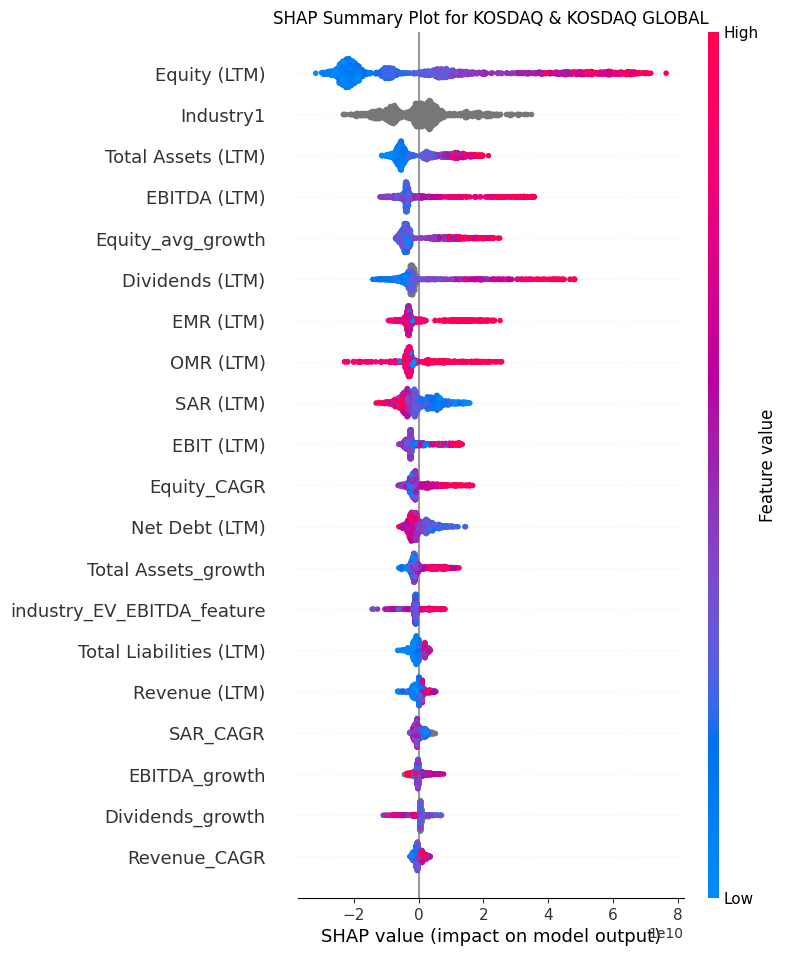


사용 가능한 변수 리스트 (79개):
  Industry1
  Industry2
  Industry3
  Industry4
  Industry5
  Net Debt (LTM)
  Total Liabilities (LTM)
  Total Assets (LTM)
  Equity (LTM)
  Revenue (LTM)
  Net Income (LTM)
  Net Income After Minority (LTM)
  EBIT (LTM)
  Dividends (LTM)
  EBITDA (LTM)
  Listing_Age_Days
  industry_PER_feature
  industry_EV_EBITDA_feature
  Total Assets_growth
  Total Assets_avg_growth
  Total Assets_CAGR
  Total Liabilities_growth
  Total Liabilities_avg_growth
  Total Liabilities_CAGR
  Equity_growth
  Equity_avg_growth
  Equity_CAGR
  Net Debt_growth
  Net Debt_avg_growth
  Net Debt_CAGR
  Revenue_growth
  Revenue_avg_growth
  Revenue_CAGR
  EBIT_growth
  EBIT_avg_growth
  EBIT_CAGR
  EBITDA_growth
  EBITDA_avg_growth
  EBITDA_CAGR
  Net Income_growth
  Net Income_avg_growth
  Net Income_CAGR
  Net Income After Minority_growth
  Net Income After Minority_avg_growth
  Net Income After Minority_CAGR
  Dividends_growth
  Dividends_avg_growth
  Dividends_CAGR
  BAR (LTM)
  DBR (LT

[I 2025-05-25 06:32:49,425] A new study created in memory with name: no-name-c578210c-ff0e-4899-883f-5840cf77e238



[KOSPI] 선택된 피처 (30개):
  Listing_Age_Days: 234.00
  Net Income After Minority (LTM): 213.00
  Equity (LTM): 204.00
  Dividends_growth: 187.00
  industry_EV_EBITDA_feature: 176.00
  Dividends_avg_growth: 172.00
  Revenue (LTM): 161.00
  Total Assets (LTM): 152.00
  Dividends (LTM): 136.00
  industry_PER_feature: 126.00
  Equity_growth: 118.00
  Total Liabilities_CAGR: 116.00
  Revenue_CAGR: 109.00
  EBIT (LTM): 107.00
  EAR_CAGR: 107.00
  Revenue_growth: 106.00
  DBR_growth: 105.00
  EMR_avg_growth: 103.00
  Dividends_CAGR: 101.00
  Net Debt_growth: 101.00
  SAR_growth: 96.00
  EBR_CAGR: 95.00
  SAR_CAGR: 94.00
  DBR_CAGR: 86.00
  Total Liabilities_avg_growth: 81.00
  Net Income After Minority_avg_growth: 81.00
  Revenue_avg_growth: 79.00
  EBITDA (LTM): 79.00
  Total Liabilities (LTM): 76.00
  Net Debt_CAGR: 75.00


[I 2025-05-25 06:32:50,031] Trial 1 finished with value: 0.7227624977573808 and parameters: {'learning_rate': 0.15982743517396214, 'num_leaves': 97, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.68782936624846, 'colsample_bytree': 0.9611302718574952, 'reg_alpha': 4.5416987180552, 'reg_lambda': 6.616218157983837}. Best is trial 1 with value: 0.7227624977573808.
[I 2025-05-25 06:32:50,236] Trial 0 finished with value: 0.7266304314438539 and parameters: {'learning_rate': 0.1069675260712794, 'num_leaves': 56, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.9513692363083395, 'colsample_bytree': 0.9231672654005975, 'reg_alpha': 2.4871364693593327, 'reg_lambda': 0.57338294555169}. Best is trial 1 with value: 0.7227624977573808.
[I 2025-05-25 06:32:50,629] Trial 2 finished with value: 0.7346918300872394 and parameters: {'learning_rate': 0.23112147693232388, 'num_leaves': 98, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.7678873849548058, 'colsample_bytree': 0.7188


[KOSPI] SHAP Feature Importances and Direction (Top 20):
양수 mean_shap_value: 시가총액 증가에 기여
음수 mean_shap_value: 시가총액 감소에 기여


,feature,shap_importance,mean_shap_value
2,Equity (LTM),1.405175e+11,1.180212e+10
8,Dividends (LTM),1.171127e+11,-9.121429e+09
13,EBIT (LTM),1.061682e+11,-5.720638e+09
9,industry_PER_feature,6.845255e+10,5.534620e+09
1,Net Income After Minority (LTM),5.471154e+10,-1.170253e+10
4,industry_EV_EBITDA_feature,3.589901e+10,3.727671e+09
7,Total Assets (LTM),2.396999e+10,4.254551e+09
0,Listing_Age_Days,2.120113e+10,-1.090227e+09
6,Revenue (LTM),1.764259e+10,3.381796e+09
27,EBITDA (LTM),1.392386e+10,-3.802634e+09



[KOSPI] SHAP Summary Plot (Top 20 Features):


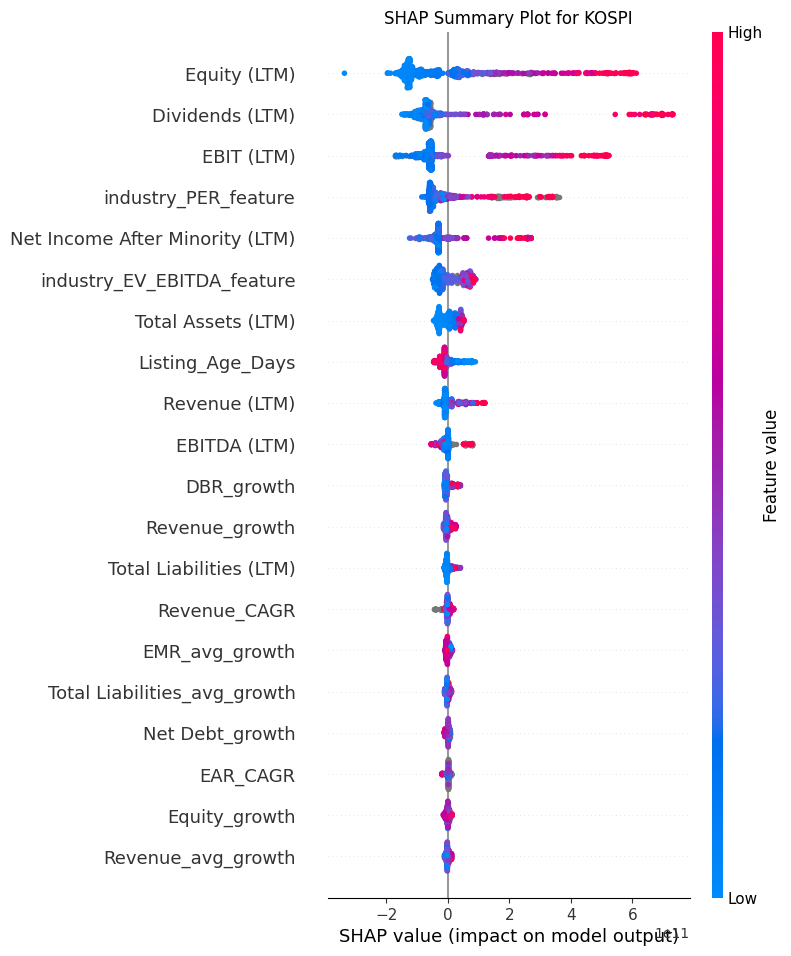

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
import optuna
import shap
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
import re
warnings.filterwarnings("ignore")

# 산업 PER 기반 피처 계산 (SA, MD, NH, AG1 방법 지원)
def calculate_industry_per_feature(df, method='NH'):
    """산업별 PER을 다양한 방법으로 계산하여 추정 시가총액 반환"""
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    industries = df[industry_cols].stack().dropna().unique()

    per_values = {}
    for ind in industries:
        mask = df[industry_cols].apply(lambda r: ind in r.values, axis=1)
        if method == 'AG1':
            sub = df.loc[mask & df['Net Income (LTM)'].notna()]  # 순이익 0 이하 포함
        else:
            sub = df.loc[mask & df['Net Income (LTM)'].gt(0) & df['Net Income (LTM)'].notna()]  # 순이익 0 초과
        if sub.empty:
            per_values[ind] = np.nan
            continue
        per_vals = sub['market_cap'] / sub['Net Income (LTM)']

        if method == 'SA':
            per_values[ind] = per_vals.mean()
        elif method == 'MD':
            per_values[ind] = per_vals.median()
        elif method == 'NH':
            per_values[ind] = len(per_vals) / (1.0 / per_vals).sum() if len(per_vals) > 0 else np.nan
        elif method == 'AG1':
            q1 = per_vals.quantile(0.25)
            q3 = per_vals.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            per_vals_filtered = per_vals[(per_vals >= lower_bound) & (per_vals <= upper_bound)]
            per_values[ind] = per_vals_filtered.mean() if len(per_vals_filtered) > 0 else np.nan

    def feature(row):
        nets = row['Net Income (LTM)']
        if pd.isna(nets):
            return np.nan
        inds = [row[c] for c in industry_cols if pd.notna(row[c])]
        pers = [per_values[i] for i in inds if not np.isnan(per_values.get(i, np.nan))]
        return np.mean(pers) * nets if pers else np.nan

    return df.apply(feature, axis=1)

# 산업 EV/EBITDA 기반 피처 계산 (SA, MD, NH, AG1 방법 지원)
def calculate_industry_EV_EBITDA_feature(df, method='NH'):
    """산업별 EV/EBITDA를 다양한 방법으로 계산하여 추정 시가총액 반환"""
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    industries = df[industry_cols].stack().dropna().unique()

    ev_ebitda_values = {}
    for ind in industries:
        mask = df[industry_cols].apply(lambda r: ind in r.values, axis=1)
        if method == 'AG1':
            sub = df.loc[mask & df['EBITDA (LTM)'].notna() & df['Enterprise Value (FQ0)'].notna()]  # EBITDA 0 이하 포함
        else:
            sub = df.loc[mask & df['EBITDA (LTM)'].gt(0) & df['EBITDA (LTM)'].notna() & df['Enterprise Value (FQ0)'].notna()]
        if sub.empty:
            ev_ebitda_values[ind] = np.nan
            continue
        ev_vals = sub['Enterprise Value (FQ0)'] / sub['EBITDA (LTM)']

        if method == 'SA':
            ev_ebitda_values[ind] = ev_vals.mean()
        elif method == 'MD':
            ev_ebitda_values[ind] = ev_vals.median()
        elif method == 'NH':
            ev_ebitda_values[ind] = len(ev_vals) / (1.0 / ev_vals).sum() if len(ev_vals) > 0 else np.nan
        elif method == 'AG1':
            q1 = ev_vals.quantile(0.25)
            q3 = ev_vals.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            ev_vals_filtered = ev_vals[(ev_vals >= lower_bound) & (ev_vals <= upper_bound)]
            ev_ebitda_values[ind] = ev_vals_filtered.mean() if len(ev_vals_filtered) > 0 else np.nan

    def feature_ev(row):
        ebitda = row['EBITDA (LTM)']
        if pd.isna(ebitda):
            return np.nan
        inds = [row[c] for c in industry_cols if pd.notna(row[c])]
        ev_ebitdas = [ev_ebitda_values[i] for i in inds if not np.isnan(ev_ebitda_values.get(i, np.nan))]
        if not ev_ebitdas:
            return np.nan
        ev_estimate = np.mean(ev_ebitdas) * ebitda
        net_debt = row.get('Net Debt (LTM)', 0)
        return ev_estimate - net_debt if pd.notna(net_debt) else np.nan

    return df.apply(feature_ev, axis=1)

# 도메인 및 시간 기반 피처 엔지니어링 클래스
class DomainFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        Xt = self._transform(X.copy())
        self.cols_ = Xt.columns.tolist()
        print(f"\n사용 가능한 변수 리스트 ({len(self.cols_)}개):")
        for col in self.cols_:
            print(f"  {col}")
        return self

    def transform(self, X):
        Xt = self._transform(X.copy())
        return Xt.reindex(columns=self.cols_, fill_value=0)

    def _transform(self, X):
        X = X.drop('market', axis=1, errors='ignore')
        tcols = [c for c in X.columns if '(' in c and 'LTM' in c]
        tf = {}
        for c in tcols:
            base, per = c.split(' (')
            tf.setdefault(base, {})[per.rstrip(')')] = c

        if 'EBIT' in tf and 'Depreciation' in tf:
            for p, e in tf['EBIT'].items():
                d = tf['Depreciation'].get(p)
                if d:
                    X[f'EBITDA ({p})'] = X[e] + X[d]
            tf['EBITDA'] = {p: f'EBITDA ({p})' for p in tf['EBIT']}

        bases = ['Total Assets', 'Total Liabilities', 'Equity', 'Net Debt',
                 'Revenue', 'EBIT', 'EBITDA', 'Net Income', 'Net Income After Minority', 'Dividends']

        def safe_div(a, b):
            return a.div(b.replace({0: np.nan}))

        for v in bases:
            periods = tf.get(v, {})
            seq = [p for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if p in periods]
            grs = []
            for i in range(1, len(seq)):
                prev, curr = seq[i-1], seq[i]
                r = safe_div(X[periods[curr]] - X[periods[prev]], X[periods[prev]])
                suffix = '-2' if (prev, curr) == ('LTM-3', 'LTM-2') else '-1' if (prev, curr) == ('LTM-2', 'LTM-1') else ''
                X[f'{v}_growth{suffix}'] = r
                grs.append(r)
            if grs:
                X[f'{v}_avg_growth'] = pd.concat(grs, axis=1).mean(axis=1)
            if 'LTM-3' in periods and 'LTM' in periods:
                X[f'{v}_CAGR'] = np.where(
                    X[periods['LTM-3']] > 0,
                    (X[periods['LTM']] / X[periods['LTM-3']])**(1/3) - 1,
                    np.nan
                )

        def calc(a, b, name, per):
            if per in tf.get(a, {}) and per in tf.get(b, {}):
                X[f'{name} ({per})'] = safe_div(X[tf[a][per]], X[tf[b][per]])

        ratios = [
            ('Equity', 'Total Assets', 'BAR'),
            ('Total Liabilities', 'Equity', 'DBR'),
            ('Revenue', 'Total Assets', 'SAR'),
            ('EBIT', 'Revenue', 'OMR'),
            ('EBITDA', 'Revenue', 'EMR'),
            ('Net Income', 'Total Assets', 'EAR'),
            ('Net Income', 'Equity', 'EBR')
        ]
        for p in ['LTM', 'LTM-1', 'LTM-2', 'LTM-3']:
            for a, b, n in ratios:
                calc(a, b, n, p)
            if p in ['LTM-2', 'LTM-1', 'LTM']:
                ni = tf.get('Net Income After Minority', {}).get(p)
                eq = tf.get('Equity', {}).get(p)
                prev = {'LTM-2': 'LTM-3', 'LTM-1': 'LTM-2', 'LTM': 'LTM-1'}[p]
                ep = tf.get('Equity', {}).get(prev)
                if ni and eq and ep:
                    avg_eq = (X[eq] + X[ep]) / 2
                    X[f'ROE ({p})'] = safe_div(X[ni], avg_eq)

        ratio_bases = ['BAR', 'DBR', 'SAR', 'OMR', 'EMR', 'EAR', 'EBR', 'ROE']
        for v in ratio_bases:
            periods = {p: f'{v} ({p})' for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if f'{v} ({p})' in X.columns}
            seq = [p for p in ['LTM-3', 'LTM-2', 'LTM-1', 'LTM'] if p in periods]
            grs = []
            for i in range(1, len(seq)):
                prev, curr = seq[i-1], seq[i]
                r = safe_div(X[periods[curr]] - X[periods[prev]], X[periods[prev]])
                suffix = '-2' if (prev, curr) == ('LTM-3', 'LTM-2') else '-1' if (prev, curr) == ('LTM-2', 'LTM-1') else ''
                X[f'{v}_growth{suffix}'] = r
                grs.append(r)
            if grs:
                X[f'{v}_avg_growth'] = pd.concat(grs, axis=1).mean(axis=1)
            if 'LTM-3' in periods and 'LTM' in periods:
                X[f'{v}_CAGR'] = np.where(
                    X[periods['LTM-3']] > 0,
                    (X[periods['LTM']] / X[periods['LTM-3']])**(1/3) - 1,
                    np.nan
                )

        dep_cols = [c for c in X.columns if c.startswith('Depreciation')]
        if dep_cols:
            X.drop(columns=dep_cols, inplace=True)

        industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
        for col in industry_cols:
            if col in X.columns:
                X[col] = X[col].astype('category')

        exclude_cols = [col for col in X.columns if re.search(r'\(LTM-\d+\)$|_growth-\d+$', col)]
        X = X.drop(columns=exclude_cols)

        return X

# LightGBM 하이퍼파라미터 최적화 (MAPE)
def optimize_lightgbm(X, y, n_trials=50):
    """LightGBM 모델의 하이퍼파라미터를 최적화하며 MAPE를 최소화"""
    def objective(trial):
        param = {
            'objective': 'quantile',
            'alpha': 0.5,
            'n_estimators': 1000,  # Large number, early stopping will adjust
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        val_mapes = []
        cat_cols = [col for col in ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5'] if col in X.columns]

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = LGBMRegressor(**param)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='quantile',
                callbacks=[early_stopping(stopping_rounds=10, verbose=False)],
                categorical_feature=cat_cols
            )
            y_pred = model.predict(X_val)
            # MAPE 계산: |actual - predicted| / |actual| for non-zero actual values
            mask = y_val != 0
            mape = np.mean(np.abs((y_val[mask] - y_pred[mask]) / y_val[mask])) if mask.sum() > 0 else np.inf
            val_mapes.append(mape)

        return np.mean(val_mapes)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)
    best_params = study.best_params
    best_params.update({
        'objective': 'quantile',
        'alpha': 0.5,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    })
    return best_params

# LightGBM 0.5 quantile 모델 실행 및 SHAP 분석
def quick_lightgbm_quantile(df, name):
    """LightGBM 0.5 quantile 모델을 실행하고 SHAP 피처 중요도 및 방향성을 계산 및 시각화"""
    df = df.copy()

    # EBITDA 생성
    if 'EBITDA (LTM)' not in df and 'EBIT (LTM)' in df and 'Depreciation (LTM)' in df:
        df['EBITDA (LTM)'] = df['EBIT (LTM)'] + df['Depreciation (LTM)']

    # 상장일 변환
    df['Listing_Age_Days'] = (pd.to_datetime('2024-12-31') - pd.to_datetime(df['Listing Date'])).dt.days
    df.drop(columns=['Listing Date'], inplace=True)

    # 산업 피처 계산 (NH 방식)
    df['industry_PER_feature'] = calculate_industry_per_feature(df, method='NH')
    df['industry_EV_EBITDA_feature'] = calculate_industry_EV_EBITDA_feature(df, method='NH')

    # 카테고리 변수 설정
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    for col in industry_cols:
        if col in df:
            df[col] = df[col].astype('category')

    # 설명 변수 선택
    X = df.select_dtypes(include=[np.number, 'category']).drop(
        columns=['Market Cap (2024-12-31)', 'market_cap', 'Enterprise Value (FQ0)'], errors='ignore')
    y = df['market_cap']

    # 피처 엔지니어링
    fe = DomainFeatureEngineer().fit(X, y)
    X_fe = fe.transform(X)

    # 피처 선택
    selector = LGBMRegressor(n_estimators=200, random_state=42)
    selector.fit(X_fe, y)
    imp = pd.Series(selector.feature_importances_, index=X_fe.columns)
    selected = imp[imp > imp.mean() * 1].sort_values(ascending=False).index.tolist()

    print(f"\n[{name}] 선택된 피처 ({len(selected)}개):")
    for feat, score in imp[imp > imp.mean()].sort_values(ascending=False).items():
        print(f"  {feat}: {score:.2f}")

    # 모델 최적화 및 학습
    X_sel = X_fe[selected]
    best_params = optimize_lightgbm(X_sel, y)
    cat_cols = [col for col in industry_cols if col in X_sel.columns]

    model = LGBMRegressor(**best_params)
    model.fit(X_sel, y, categorical_feature=cat_cols)

    # SHAP 값 계산
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sel)

    # 피처 중요도 및 방향성 계산
    shap_importances = np.abs(shap_values).mean(axis=0)
    shap_means = np.mean(shap_values, axis=0)  # 평균 SHAP 값 (방향성)
    feature_importance_df = pd.DataFrame({
        'feature': X_sel.columns,
        'shap_importance': shap_importances,
        'mean_shap_value': shap_means
    }).sort_values(by='shap_importance', ascending=False)

    # 상위 20개 피처의 중요도와 방향성 출력
    print(f"\n[{name}] SHAP Feature Importances and Direction (Top 20):")
    print("양수 mean_shap_value: 시가총액 증가에 기여")
    print("음수 mean_shap_value: 시가총액 감소에 기여")
    display(feature_importance_df.head(20))

    # SHAP Summary Plot (Beeswarm)
    print(f"\n[{name}] SHAP Summary Plot (Top 20 Features):")
    shap.summary_plot(shap_values, X_sel, max_display=20, show=False)
    plt.title(f"SHAP Summary Plot for {name}")
    display(plt.gcf())
    plt.close()

    return feature_importance_df

# 메인 실행
if __name__ == "__main__":
    PATH = "/content/5_7_데이터.xlsx"
    df = pd.read_excel(PATH, sheet_name="Sheet1")

    # 데이터 전처리
    industry_cols = ['Industry1', 'Industry2', 'Industry3', 'Industry4', 'Industry5']
    for col in industry_cols:
        if col in df:
            df[col] = df[col].astype('category')

    df = df[df["market"].isin(["KOSDAQ", "KOSDAQ GLOBAL", "KOSPI"]) & (df["Market Cap (2024-12-31)"] > 0)]
    df["market_cap"] = df["Market Cap (2024-12-31)"]

    exclude_tickers = set(['003380', '005290', '005990', '006730', '007330', '012700', '013120', '013310', '015750', '016250',
                           '018310', '019210', '021320', '023410', '023760', '025900', '025980', '027710', '028300', '030530',
                           '031330', '032190', '033160', '033290', '033640', '034810', '035080', '035600', '035760', '035810',
                           '035890', '035900', '036710', '036800', '036830', '036930', '037460', '038110', '038390', '038500',
                           '038540', '041190', '041510', '043370', '046890', '049070', '051500', '053700', '056190', '058470',
                           '061970', '064760', '064820', '067160', '067170', '067310', '067570', '067990', '069080', '071460',
                           '074600', '078020', '078340', '080420', '084110', '084850', '085660', '086520', '091700', '092190',
                           '096530', '100790', '101330', '104480', '112040', '115160', '121440', '122450', '122690', '123040',
                           '124500', '131970', '136480', '137400', '141080', '145020', '151860', '178320', '195940', '205470',
                           '214450', '215000', '215200', '222800', '240810', '247540', '253450', '263750', '267980', '293490',
                           '348370', '357780', '393890', '403870', '900290', '950130', '000270', '000660', '000810', '000880',
                           '001040', '003490', '003550', '004020', '005380', '005490', '005830', '005930', '005940', '006400',
                           '006800', '009540', '010950', '011170', '011200', '012330', '015760', '016360', '017670', '023530',
                           '023590', '024110', '028260', '030200', '032830', '034220', '034730', '035420', '035720', '036460',
                           '042660', '051910', '055550', '066570', '071050', '078930', '086790', '088350', '096770', '097950',
                           '105560', '138040', '138930', '139130', '139480', '207940', '267250', '316140', '373220', '402340',
                           '415640'])
    df = df[~df['ticker'].isin(exclude_tickers)].reset_index(drop=True)

    num_cols = df.select_dtypes(include=[np.number]).columns
    df = df[df[num_cols].isnull().mean(axis=1) <= 0.5].reset_index(drop=True)

    # 시장별 데이터 분리 및 모델 실행
    kosdaq = df[df["market"].isin(["KOSDAQ", "KOSDAQ GLOBAL"])]
    kospi = df[df["market"] == "KOSPI"]

    res1 = quick_lightgbm_quantile(kosdaq, "KOSDAQ & KOSDAQ GLOBAL")
    res2 = quick_lightgbm_quantile(kospi, "KOSPI")